# Initial Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from collections import defaultdict
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Preprocessing

In [2]:
# Preprocess dataset (Outputs: ids, trial_nums, predictors_df, outcomes_df, outcomes_df_shuffled)
# Import dataset
df = pd.read_csv("./../../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv").replace([np.inf, -np.inf], np.nan)

# Create Low vs High Columns
df["Lv_1_Lo"] = (df["SA1"] < 5).astype(np.bool_)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(np.bool_)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(np.bool_)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(np.bool_)

# Impute missing values with mean of column
for col in df.columns:
    df[col] = df[col].fillna(value = df[col].mean())

# Split up dataset
ids = df["ID"].astype(np.uint8)
predictors_df = df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal", "Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]).astype(np.float64)
outcomes_df = df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]
outcomes_df_shuffled = outcomes_df.copy()

# Shuffle labels for shuffled data
outcomes_df_shuffled["Lv_1_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_1_Lo"])
outcomes_df_shuffled["Lv_2_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_2_Lo"])
outcomes_df_shuffled["Lv_3_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_3_Lo"])
outcomes_df_shuffled["Tot_Lo"] = np.random.permutation(outcomes_df_shuffled["Tot_Lo"])

# Divide up dataframe
ids = df["ID"]
ECG_df = df.loc[:, [col for col in df if col.startswith("ECG")]]
EDA_df = df.loc[:, [col for col in df if col.startswith("EDA")]]
EEG_df = df.loc[:, [col for col in df if col.startswith("EEG")]]
EYE_df = df.loc[:, [col for col in df if col.startswith("EYE")]]
fNIRS_df = df.loc[:, [col for col in df if col.startswith("fNIRS")]]
RSP_df = df.loc[:, [col for col in df if col.startswith("RSP")]]

# Free up memory
del col, df, predictors_df

In [3]:
# Initialize f1_scores, accuracy_scores, CV_models, and modified_Ridge_features
sensor_names = ["ECG", "EDA", "EEG", "EYE", "fNIRS", "RSP"]
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]

f1_scores = {}
accuracy_scores = {}
CV_models = {}
modified_Ridge_features = {}

for data in [f1_scores, accuracy_scores, CV_models, modified_Ridge_features]:
    for dataset in dataset_types:
        data[dataset] = {}

        for sensor in sensor_names:
            data[dataset][sensor] = {}

            for level in levels:
                data[dataset][sensor][level] = []

del dataset_types, levels, data, dataset, sensor, level

# Training

In [4]:
def evaluate_models(pred_df, out_df, ids):
    f1_scores = defaultdict(list)
    accuracy_scores = defaultdict(list)
    models = defaultdict(list)
    modified_Ridge_selected_features = []

    # Obtain 10 test folds stratifying by participant ID
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (CV_idx, test_idx) in enumerate(skf.split(pred_df, ids)):
        # Train-Test Split for the Fold
        pred_CV = pred_df.iloc[CV_idx, :].values
        pred_test = pred_df.iloc[test_idx, :].values
        out_CV = out_df.iloc[CV_idx].values
        out_test = out_df.iloc[test_idx].values

        # Standardize Data
        scaler = StandardScaler()
        pred_CV_normalized = scaler.fit_transform(pred_CV)
        pred_test_normalized = scaler.transform(pred_test)

        # Free Up Memory
        del pred_CV
        del pred_test

        # Initialize Models to Train
        no_penalty_model = LogisticRegression(
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = None,
            random_state = 42
        )

        Ridge_model = LogisticRegression(
            C = 0.001,
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = "l2",
            random_state = 42
        )

        LASSO_model = LogisticRegression(
            C = 1,
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = "l1",
            random_state = 42
        )

        modified_Ridge_model_l2 = LogisticRegression(
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = "l2",
            C = 0.001
        )

        # Fit Models
        no_penalty_model.fit(pred_CV_normalized, out_CV)
        Ridge_model.fit(pred_CV_normalized, out_CV)
        LASSO_model.fit(pred_CV_normalized, out_CV)

        # Obtain and fit "Modified Ridge" Model
        Ridge_selector = SelectFromModel(Ridge_model, prefit = True)
        Ridge_selected_features = Ridge_selector.get_support()
        pred_CV_selected_Ridge = pred_CV_normalized[:, Ridge_selected_features]
        pred_test_selected_Ridge = pred_test_normalized[:, Ridge_selected_features]
        modified_Ridge_model_l2.fit(pred_CV_selected_Ridge, out_CV)

        # Append F1 Scores
        f1_scores["No Penalty"].append(f1_score(out_test, no_penalty_model.predict(pred_test_normalized)))
        f1_scores["Ridge"].append(f1_score(out_test, Ridge_model.predict(pred_test_normalized)))
        f1_scores["LASSO"].append(f1_score(out_test, LASSO_model.predict(pred_test_normalized)))
        f1_scores["Modified Ridge (L2)"].append(f1_score(out_test, modified_Ridge_model_l2.predict(pred_test_selected_Ridge)))

        # Append accuracy Scores
        accuracy_scores["No Penalty"].append(accuracy_score(out_test, no_penalty_model.predict(pred_test_normalized)))
        accuracy_scores["Ridge"].append(accuracy_score(out_test, Ridge_model.predict(pred_test_normalized)))
        accuracy_scores["LASSO"].append(accuracy_score(out_test, LASSO_model.predict(pred_test_normalized)))
        accuracy_scores["Modified Ridge (L2)"].append(accuracy_score(out_test, modified_Ridge_model_l2.predict(pred_test_selected_Ridge)))

        # Add Models and Scores to Dictionaries
        models["No Penalty"].append(no_penalty_model)
        models["Ridge"].append(Ridge_model)
        models["LASSO"].append(LASSO_model)
        models["Modified Ridge (L2)"].append(modified_Ridge_model_l2)

        # Store selected features for relaxed LASSO
        modified_Ridge_selected_features.append(Ridge_selected_features)

    return f1_scores, accuracy_scores, models, modified_Ridge_selected_features

In [7]:
for outcome_var in ["Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    for outcome_type in ["Actual", "Shuffled"]:
        for sensor, df in [("ECG", ECG_df), ("EDA", EDA_df), ("EEG", EEG_df), ("EYE", EYE_df), ("fNIRS", fNIRS_df), ("RSP", RSP_df)]:
            if outcome_type == "Actual":
                f1_scores[outcome_type][sensor][outcome_var], accuracy_scores[outcome_type][sensor][outcome_var], CV_models[outcome_type][sensor][outcome_var], modified_Ridge_features[outcome_type][sensor][outcome_var] = evaluate_models(df, outcomes_df[outcome_var], ids)
            else:
                f1_scores[outcome_type][sensor][outcome_var], accuracy_scores[outcome_type][sensor][outcome_var], CV_models[outcome_type][sensor][outcome_var], modified_Ridge_features[outcome_type][sensor][outcome_var] = evaluate_models(df, outcomes_df_shuffled[outcome_var], ids)
            
            print("Completed Training for", outcome_type, outcome_var, sensor)

Completed Training for Actual Lv_2_Lo ECG
Completed Training for Actual Lv_2_Lo EDA
Completed Training for Actual Lv_2_Lo EEG
Completed Training for Actual Lv_2_Lo EYE
Completed Training for Actual Lv_2_Lo fNIRS
Completed Training for Actual Lv_2_Lo RSP
Completed Training for Shuffled Lv_2_Lo ECG
Completed Training for Shuffled Lv_2_Lo EDA
Completed Training for Shuffled Lv_2_Lo EEG
Completed Training for Shuffled Lv_2_Lo EYE
Completed Training for Shuffled Lv_2_Lo fNIRS
Completed Training for Shuffled Lv_2_Lo RSP
Completed Training for Actual Lv_3_Lo ECG
Completed Training for Actual Lv_3_Lo EDA
Completed Training for Actual Lv_3_Lo EEG
Completed Training for Actual Lv_3_Lo EYE
Completed Training for Actual Lv_3_Lo fNIRS
Completed Training for Actual Lv_3_Lo RSP
Completed Training for Shuffled Lv_3_Lo ECG
Completed Training for Shuffled Lv_3_Lo EDA
Completed Training for Shuffled Lv_3_Lo EEG
Completed Training for Shuffled Lv_3_Lo EYE
Completed Training for Shuffled Lv_3_Lo fNIRS
Comp

In [6]:
outcome_var = "Lv_1_Lo"
for outcome_type in ["Actual", "Shuffled"]:
    for sensor, df in [("ECG", ECG_df), ("EDA", EDA_df), ("EEG", EEG_df), ("EYE", EYE_df), ("fNIRS", fNIRS_df), ("RSP", RSP_df)]:
        if outcome_type == "Actual":
            f1_scores[outcome_type][sensor][outcome_var], accuracy_scores[outcome_type][sensor][outcome_var], CV_models[outcome_type][sensor][outcome_var], modified_Ridge_features[outcome_type][sensor][outcome_var] = evaluate_models(df, outcomes_df[outcome_var], ids)
        else:
            f1_scores[outcome_type][sensor][outcome_var], accuracy_scores[outcome_type][sensor][outcome_var], CV_models[outcome_type][sensor][outcome_var], modified_Ridge_features[outcome_type][sensor][outcome_var] = evaluate_models(df, outcomes_df_shuffled[outcome_var], ids)
        
        print("Completed Training for", outcome_type, outcome_var, sensor)

Completed Training for Actual Lv_1_Lo ECG
Completed Training for Actual Lv_1_Lo EDA
Completed Training for Actual Lv_1_Lo EEG
Completed Training for Actual Lv_1_Lo EYE
Completed Training for Actual Lv_1_Lo fNIRS
Completed Training for Actual Lv_1_Lo RSP
Completed Training for Shuffled Lv_1_Lo ECG
Completed Training for Shuffled Lv_1_Lo EDA
Completed Training for Shuffled Lv_1_Lo EEG
Completed Training for Shuffled Lv_1_Lo EYE
Completed Training for Shuffled Lv_1_Lo fNIRS
Completed Training for Shuffled Lv_1_Lo RSP


In [8]:
# # Save data
# with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor.pkl", "wb") as f:
#     pickle.dump((f1_scores, accuracy_scores, CV_models, modified_Ridge_features), f)

In [4]:
# Load data
with open("./../../Pickle Files/3_Moving_Average_Model_by_Sensor.pkl", "rb") as f:
    f1_scores, accuracy_scores, CV_models, modified_Ridge_features = pickle.load(f)

# Graphing

In [26]:
def sensor_actual_vs_shuffled(model_scores, outcomes_df, outcome_var, metric):
    for sensor in ["ECG", "EDA", "EEG", "EYE", "fNIRS", "RSP"]:
        # Intiailize Baselines
        baselines = []
        always_true_lines = []
        always_false_lines = []

        # Get baselines for each fold
        skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
        for i, (CV_idx, test_idx) in enumerate(skf.split(outcomes_df, ids)):
            # Train-Test Split for the Fold
            out_test = outcomes_df.iloc[test_idx]

            if metric == "F1":
                baselines.append((np.mean(out_test[outcome_var])) / (np.mean(out_test[outcome_var]) + 0.5))
                always_true_lines.append(f1_score(out_test[outcome_var], np.array([1 for _ in range(len(out_test[outcome_var]))])))
            elif metric == "Accuracy":
                baselines.append(0.5)
                always_false_lines.append(accuracy_score(outcomes_df[outcome_var], np.array([0 for _ in range(len(outcomes_df[outcome_var]))])))

        fig, axes = plt.subplots(2, 2, sharex = True, sharey = True)
        fig.set_figheight(7.5)
        fig.set_figwidth(7.5)

        for _, (ax, penalty) in enumerate([(axes[0, 0], "No Penalty"), (axes[0, 1], "Ridge") , (axes[1, 0], "LASSO"), (axes[1, 1], "Modified Ridge (L2)")]):
            actual_scores = model_scores["Actual"][sensor][outcome_var][penalty]
            shuffled_scores = model_scores["Shuffled"][sensor][outcome_var][penalty]

            # Plot Actual vs Shuffled
            for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
                ax.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

            # Model 1 Data Boxplot
            ax.boxplot(actual_scores, vert = True, positions = [-0.1])

            # Shuffled Data Boxplot
            ax.boxplot(shuffled_scores, vert = True, positions = [1.1])

            # Baselines
            if metric == "F1":
                ax.axhline(y = np.mean(always_true_lines), color = "r", label = "Always True", linestyle = "--")
            elif metric == "Accuracy":
                ax.axhline(y = np.mean(always_false_lines), color = "b", label = "Always True", linestyle = "--")
            ax.axhline(y = np.mean(baselines), color = "black", label = "Baseline", linestyle = "--")

            # Visual Adjustments
            ax.set_xticks([0, 1], ["Actual", "Shuffled"])
            ax.set_xlim([-0.2, 1.2])
            ax.set_ylim([0, 1])

            # Labeling Per Graph
            ax.set_title(penalty)
        
        # Labeling
        fig.supxlabel("Model Type")
        fig.supylabel(f"{metric} Score")
        fig.suptitle(f"{sensor} {metric} Test Fold Scores for {outcome_var} Models")

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc = "upper right", bbox_to_anchor = [1.2, 0.9])
        fig.tight_layout()
        fig.show()

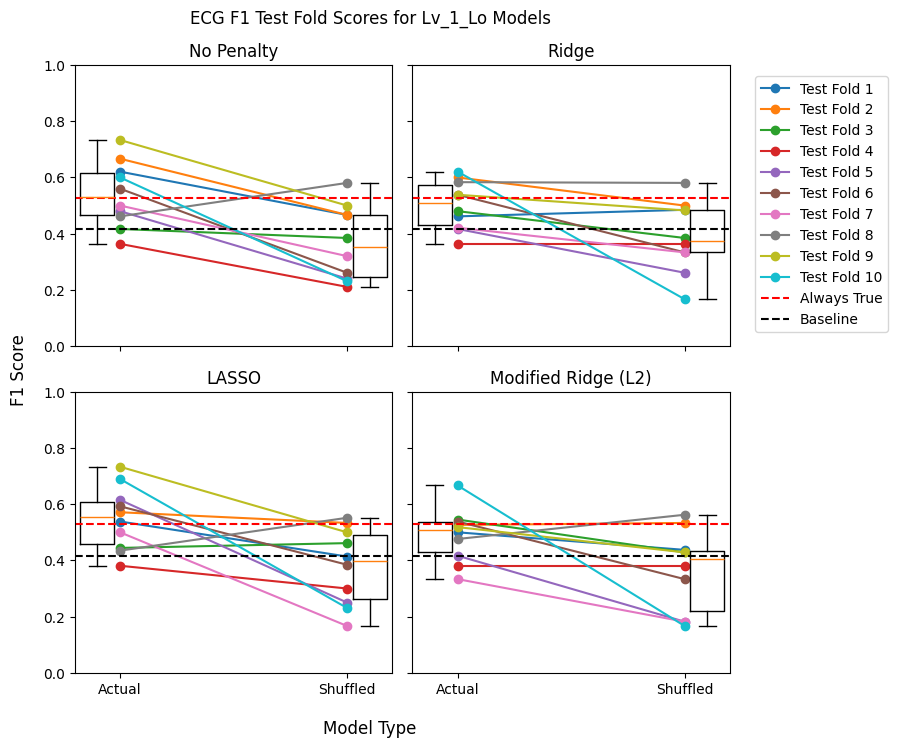

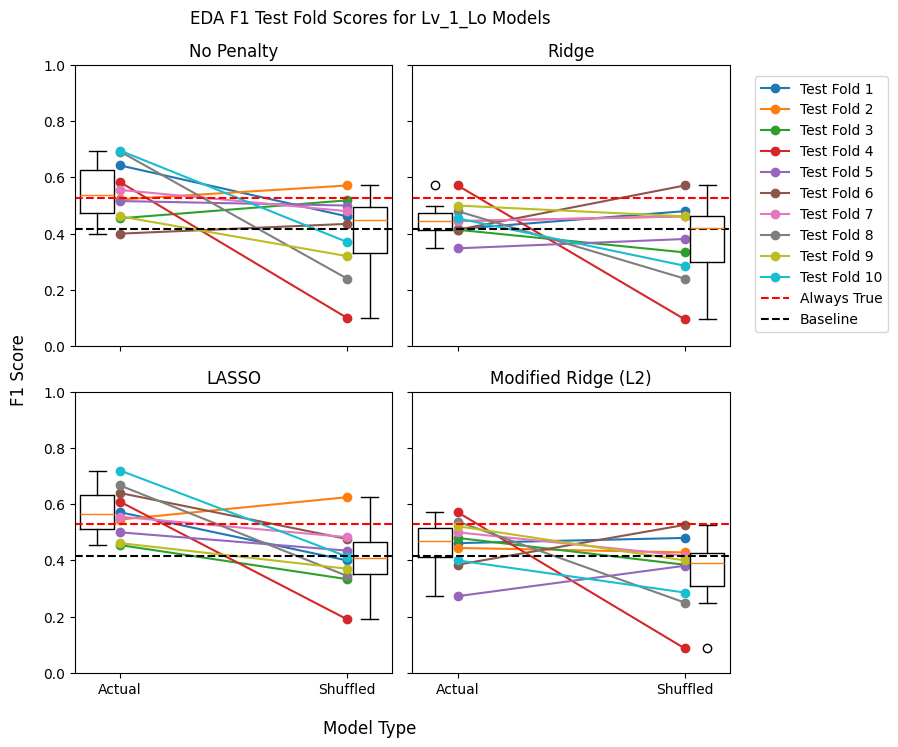

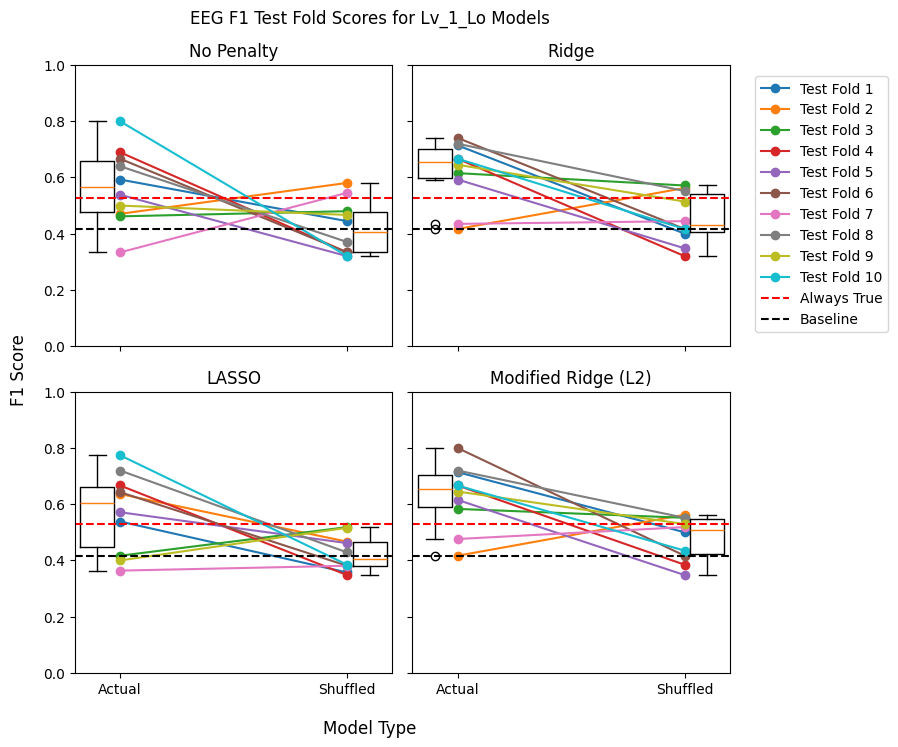

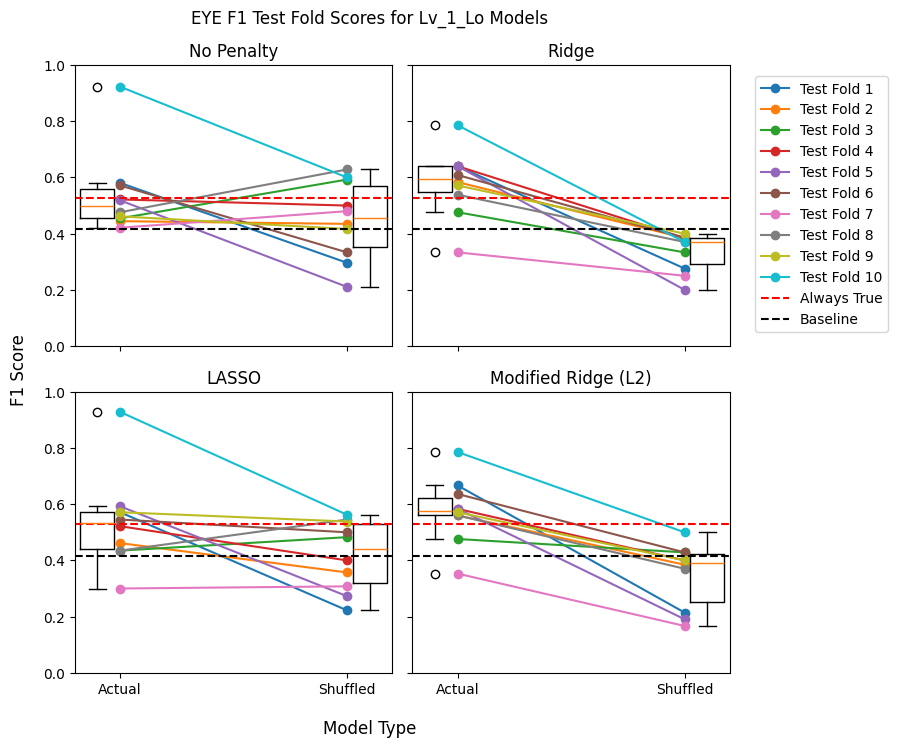

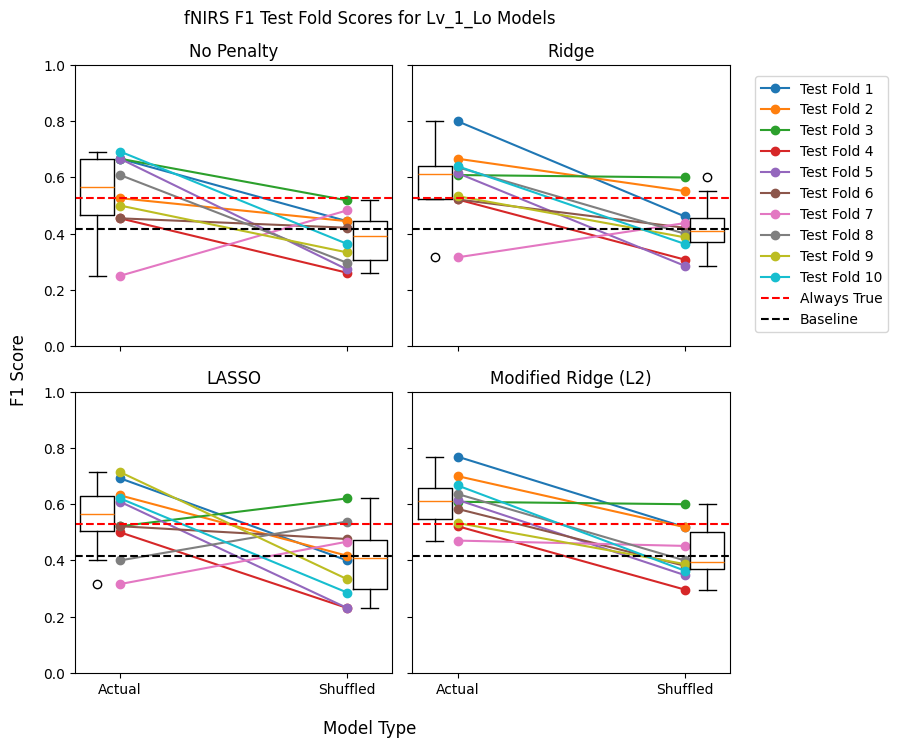

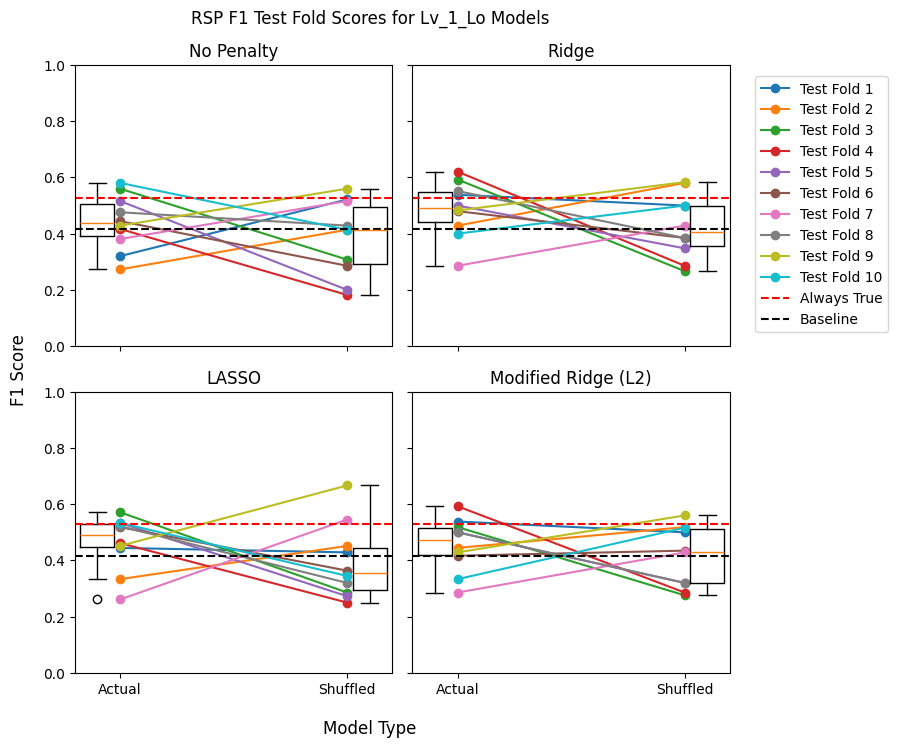

In [21]:
sensor_actual_vs_shuffled(f1_scores, outcomes_df, "Lv_1_Lo", "F1")

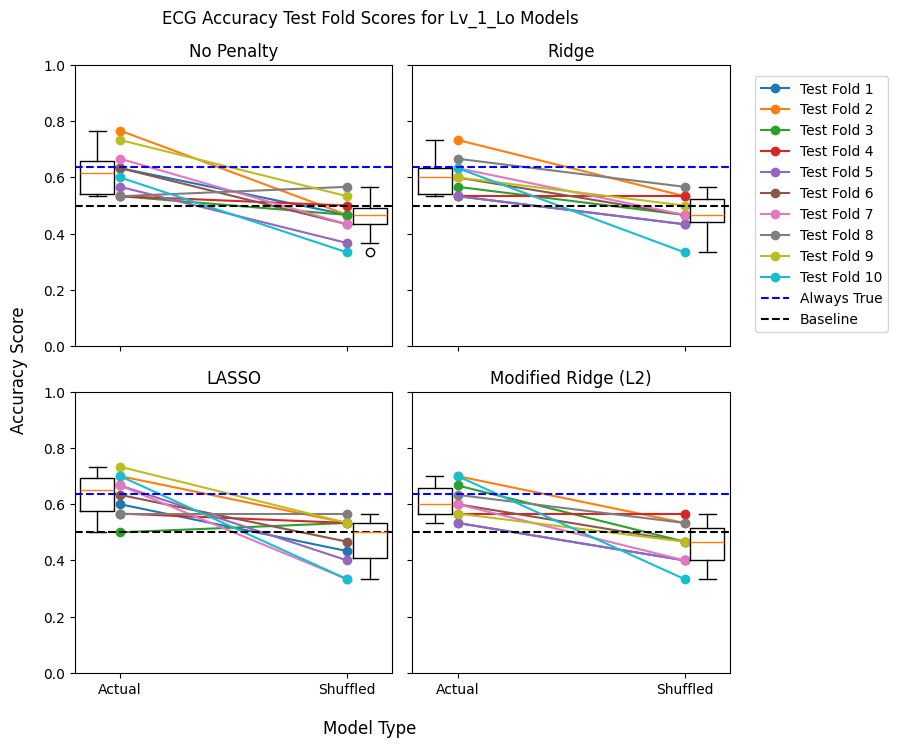

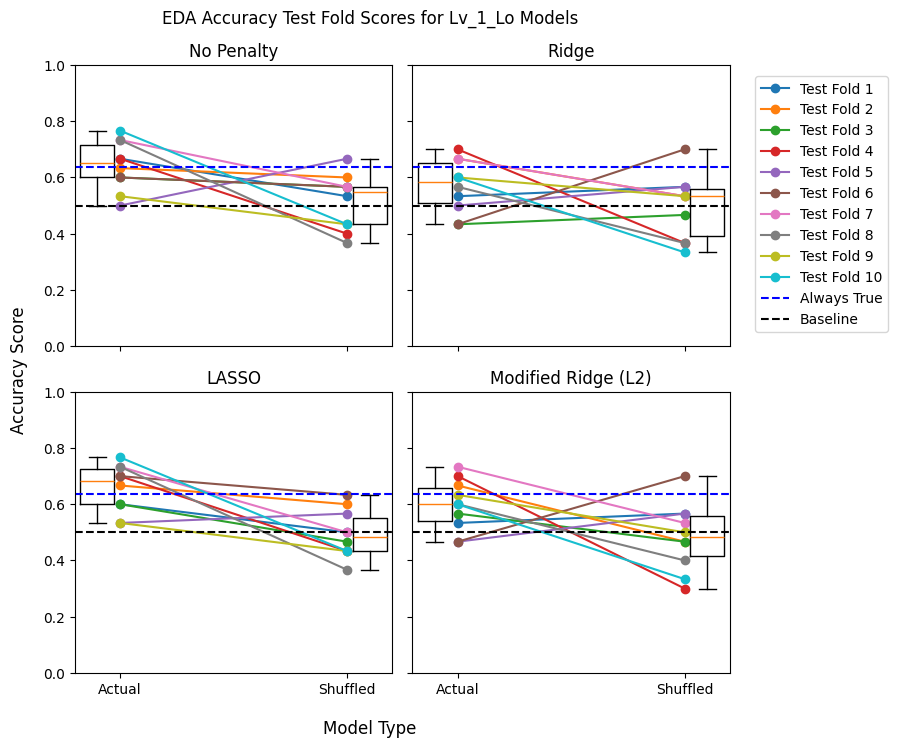

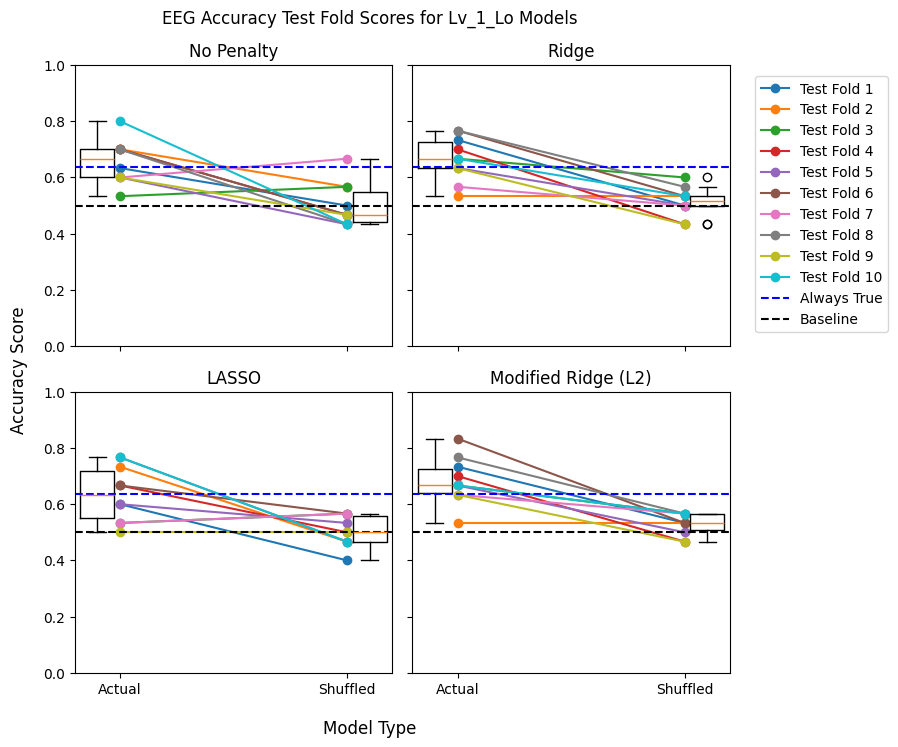

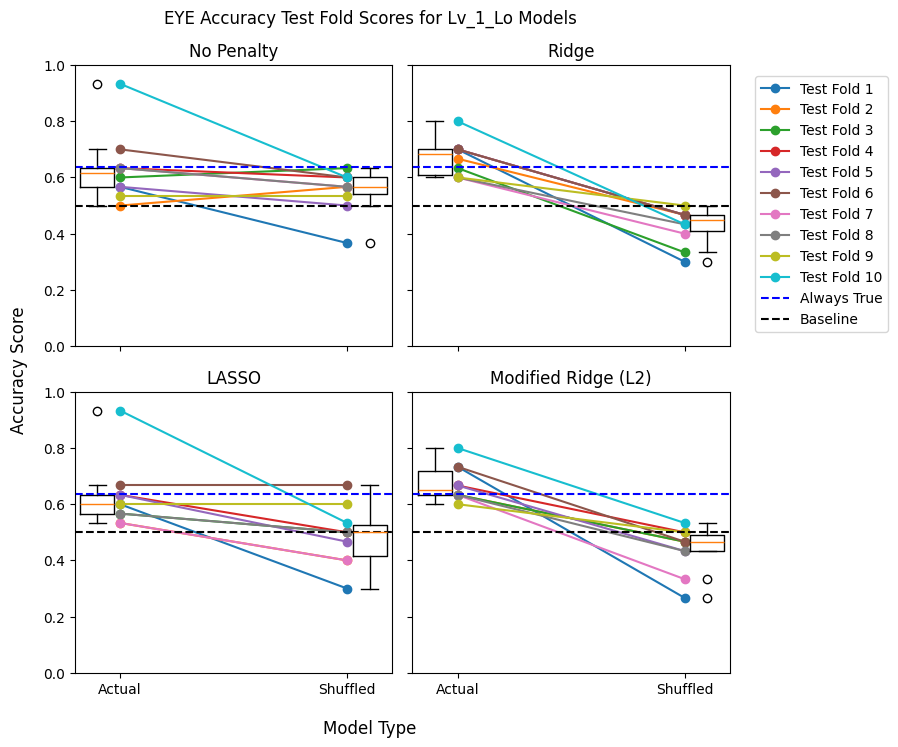

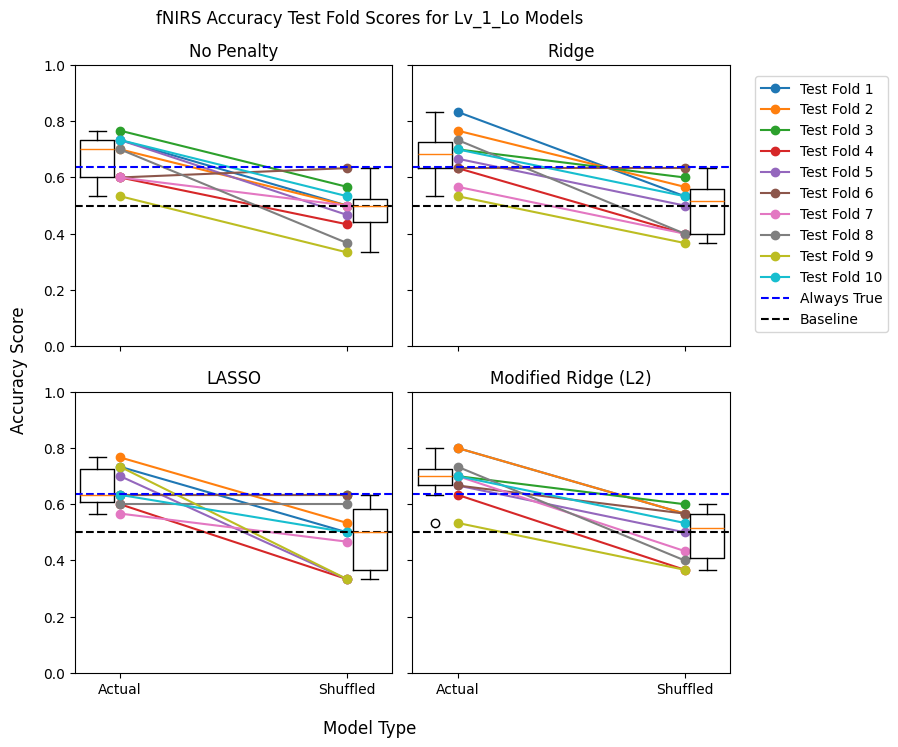

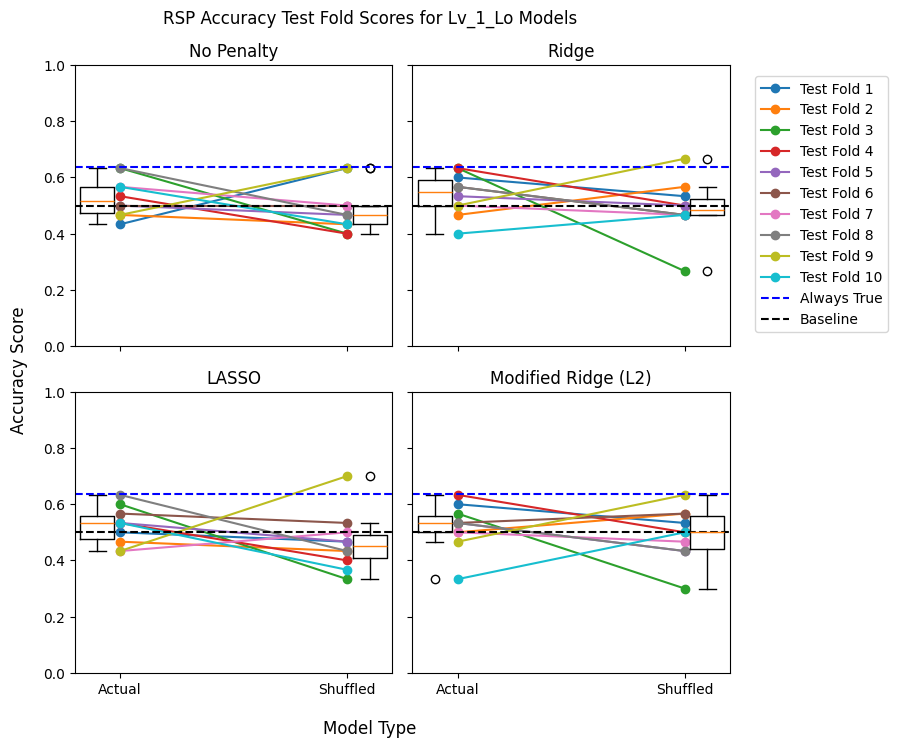

In [38]:
sensor_actual_vs_shuffled(accuracy_scores, outcomes_df, "Lv_1_Lo", "Accuracy")

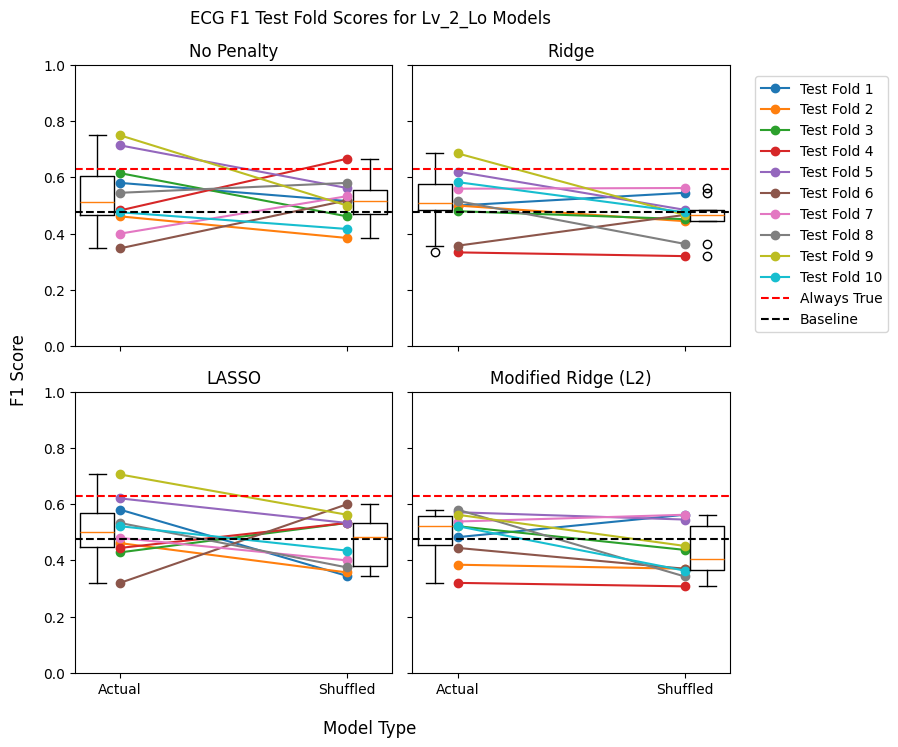

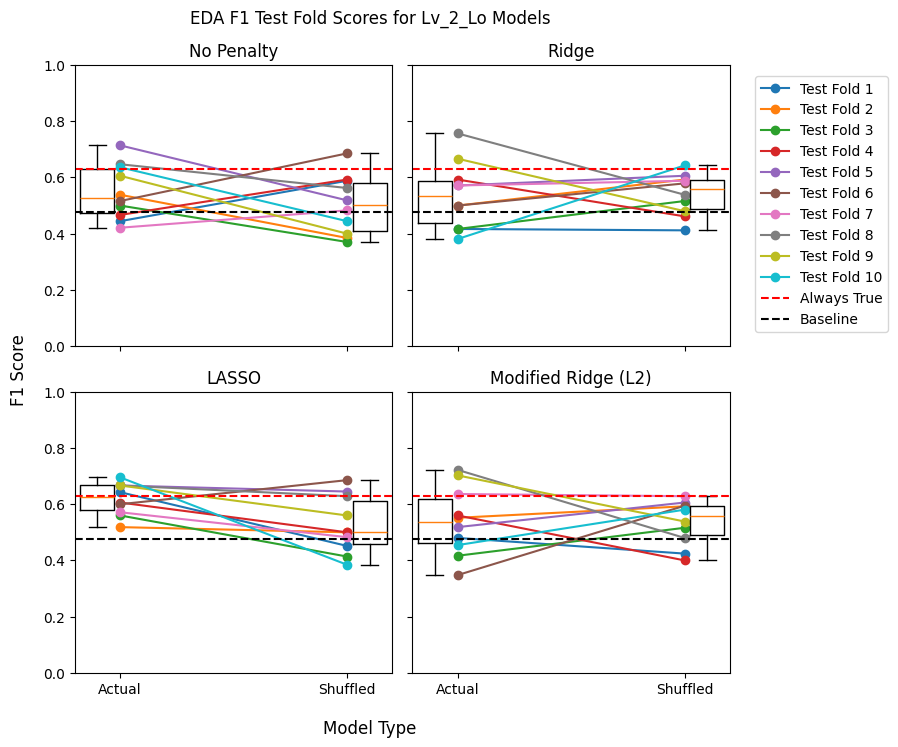

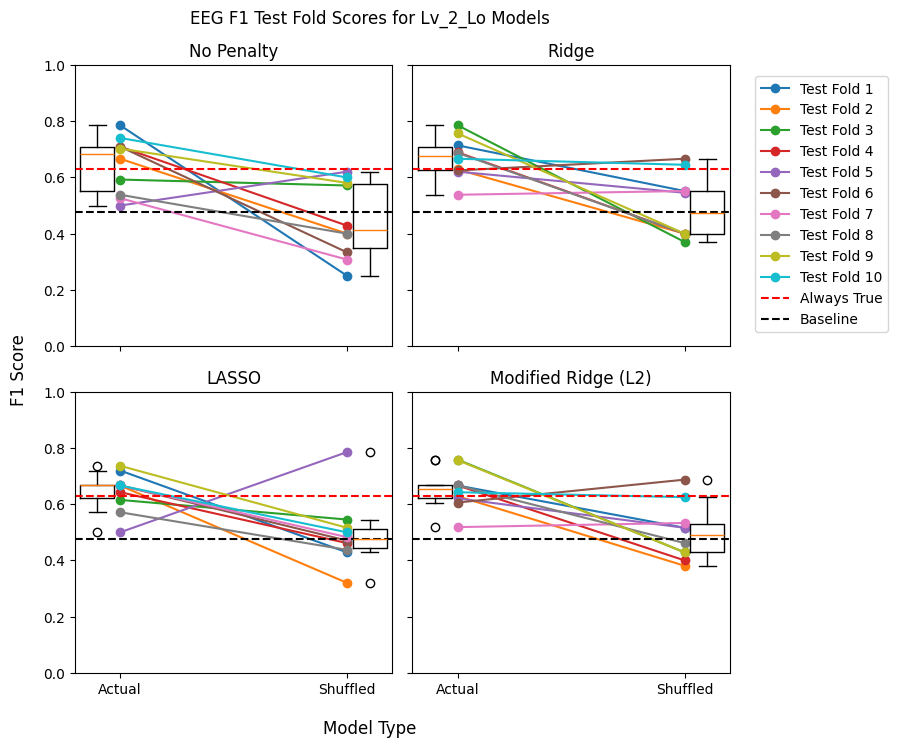

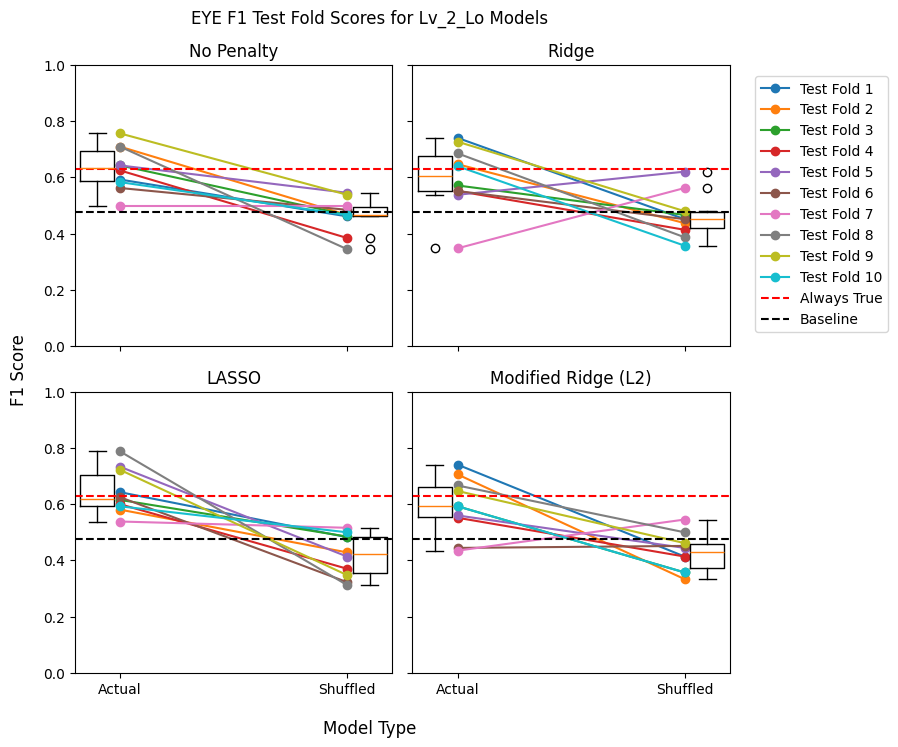

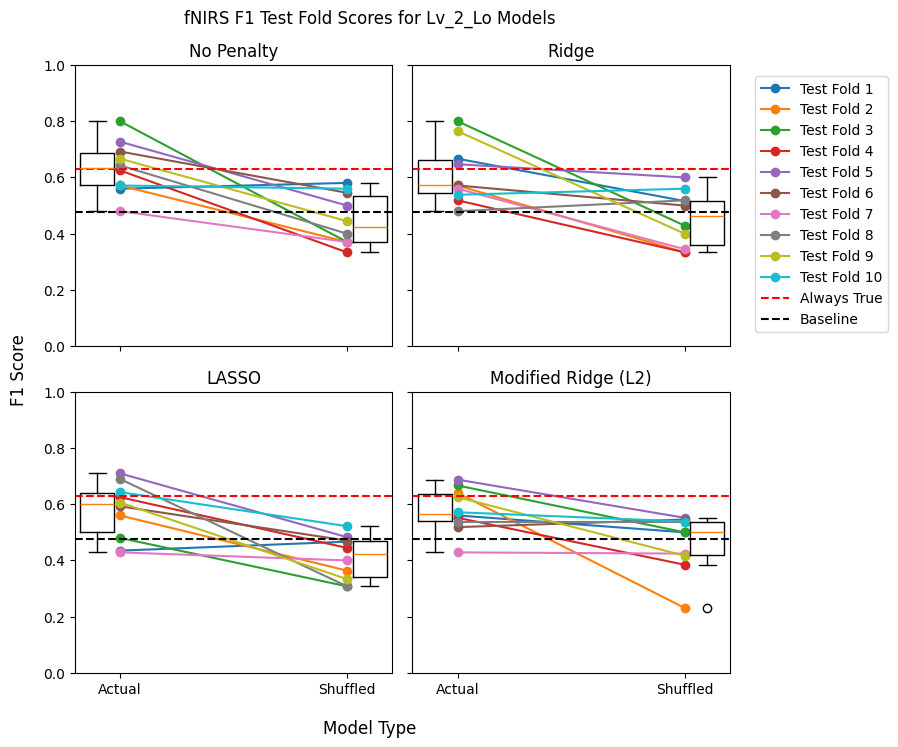

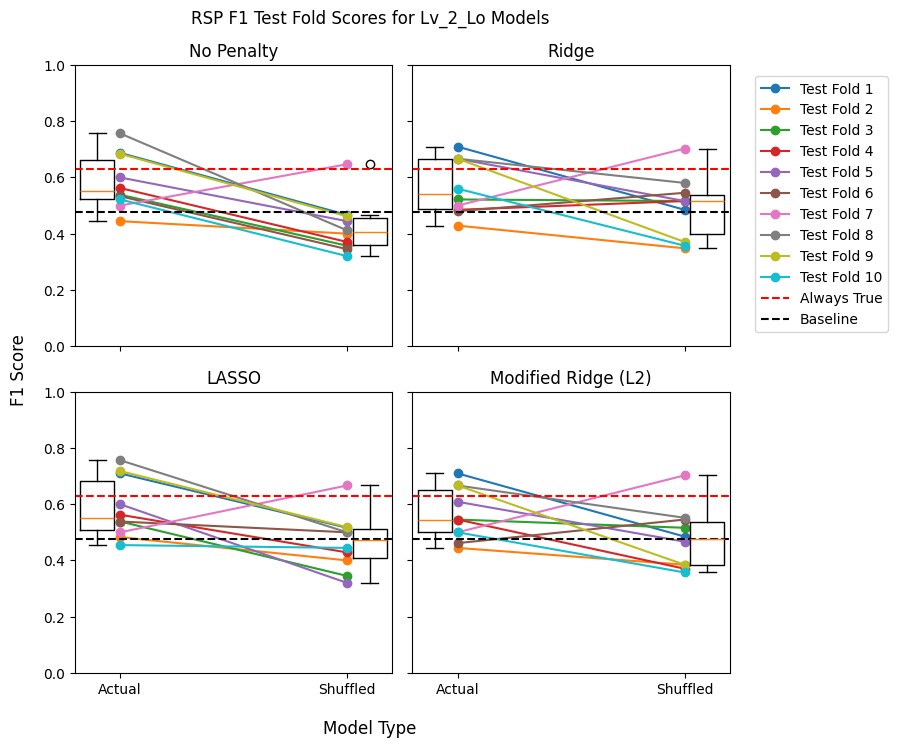

In [28]:
sensor_actual_vs_shuffled(f1_scores, outcomes_df, "Lv_2_Lo", "F1")

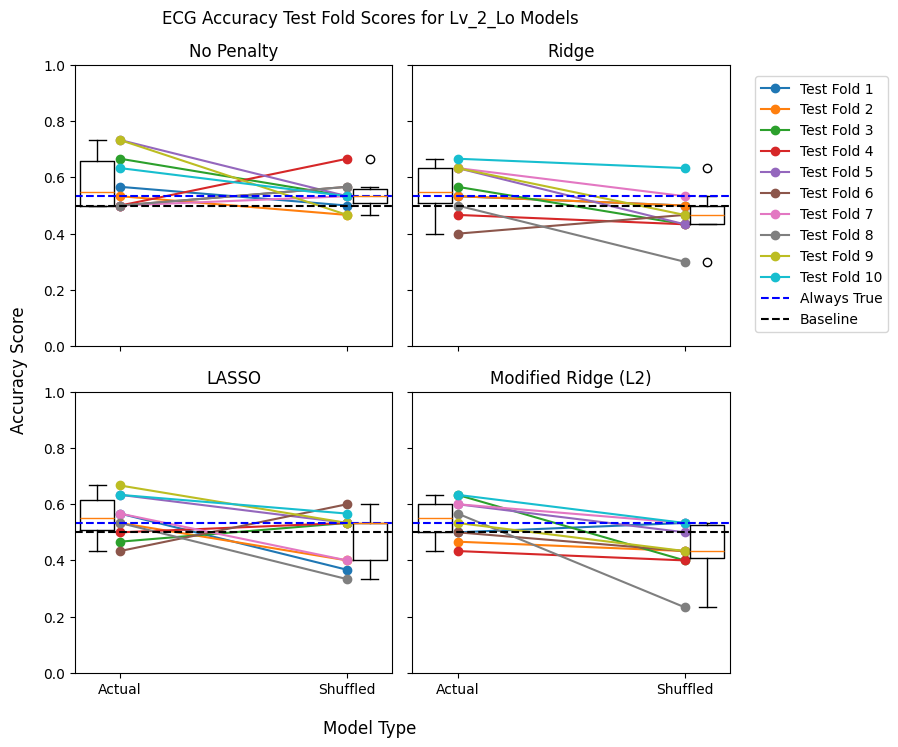

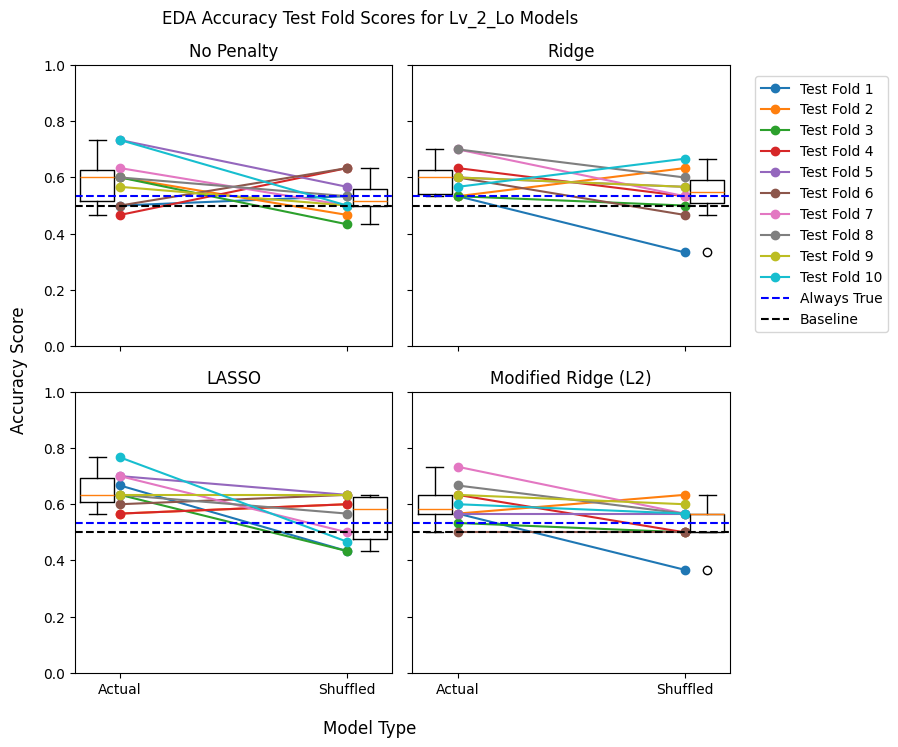

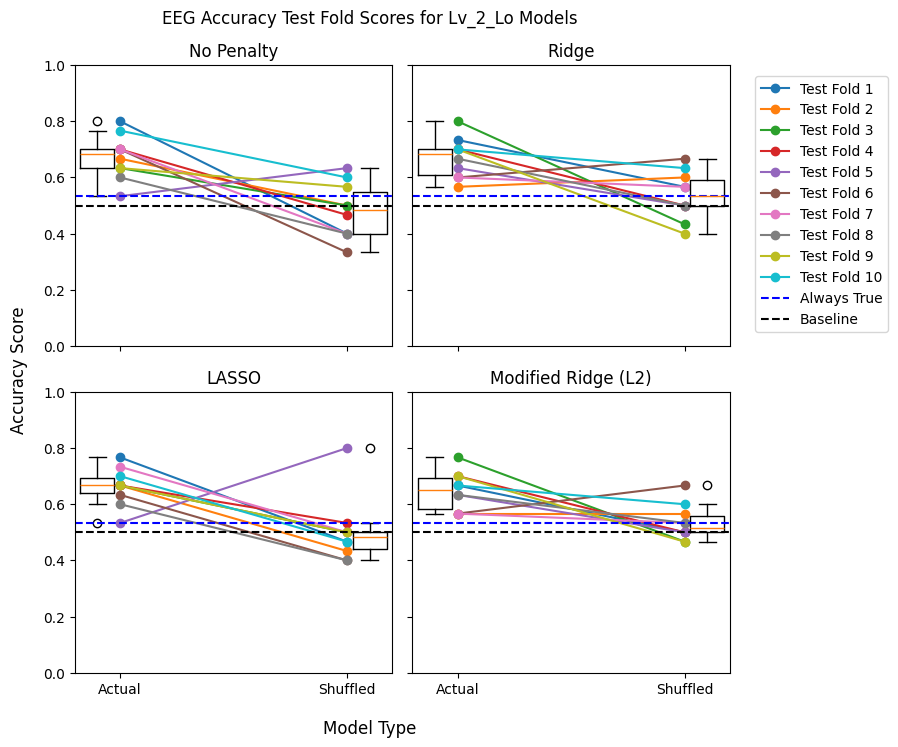

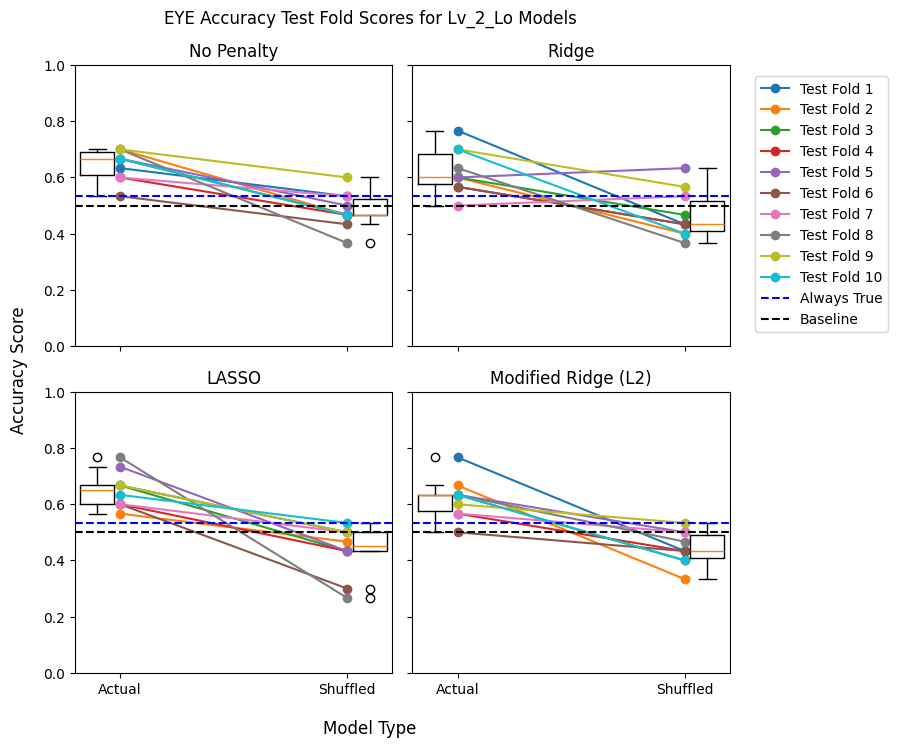

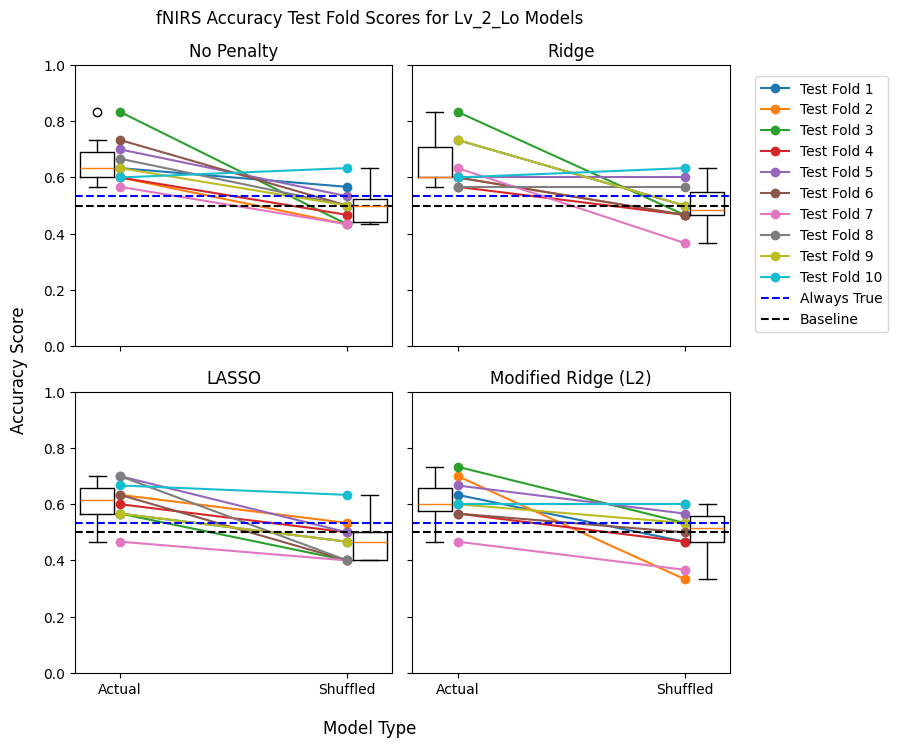

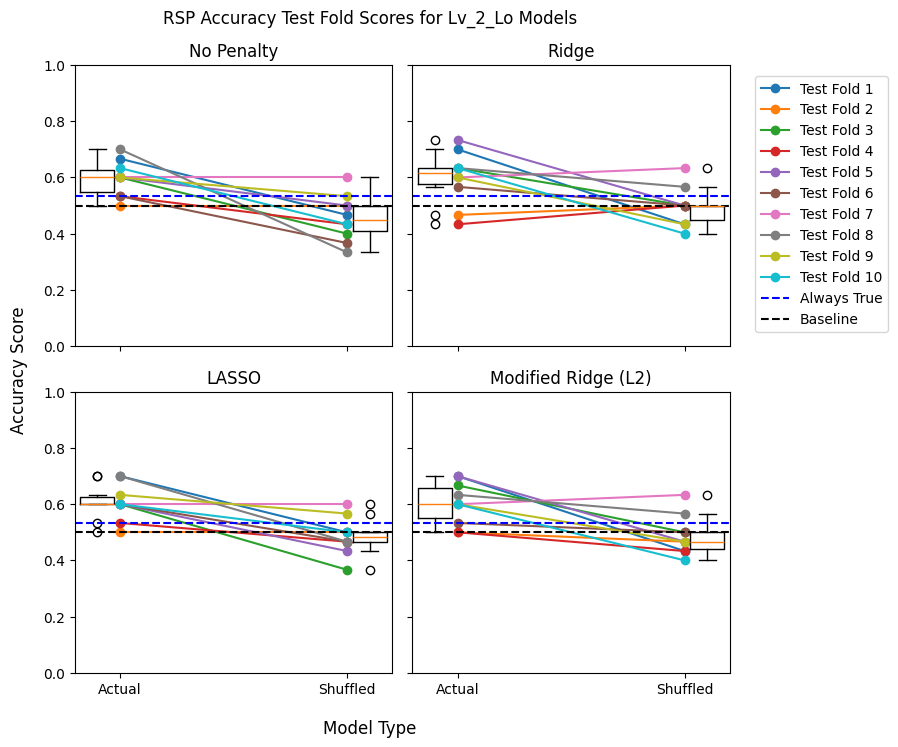

In [39]:
sensor_actual_vs_shuffled(accuracy_scores, outcomes_df, "Lv_2_Lo", "Accuracy")

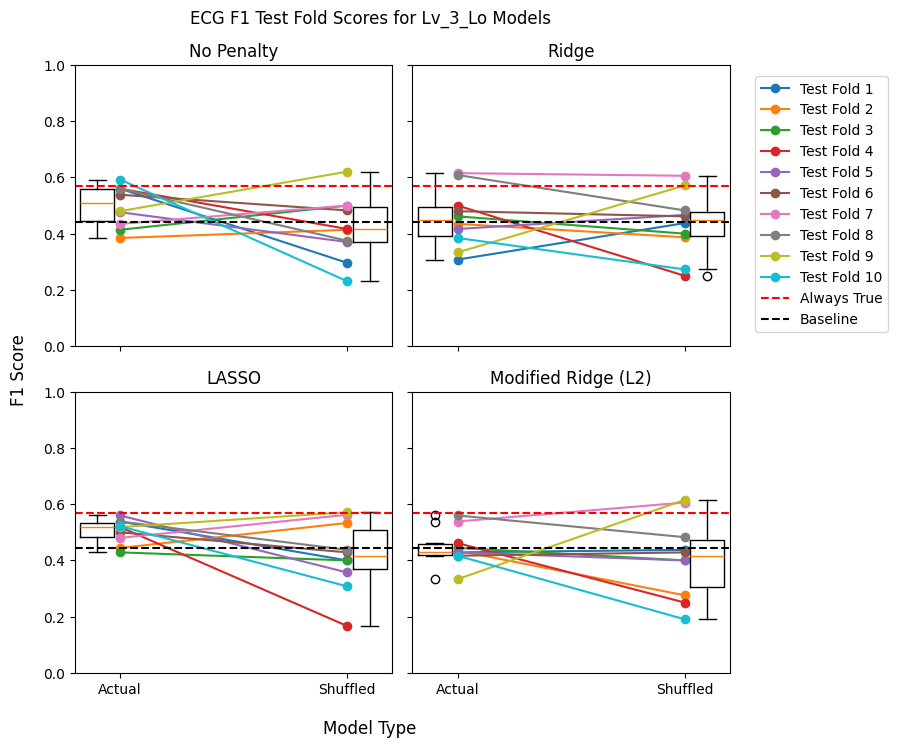

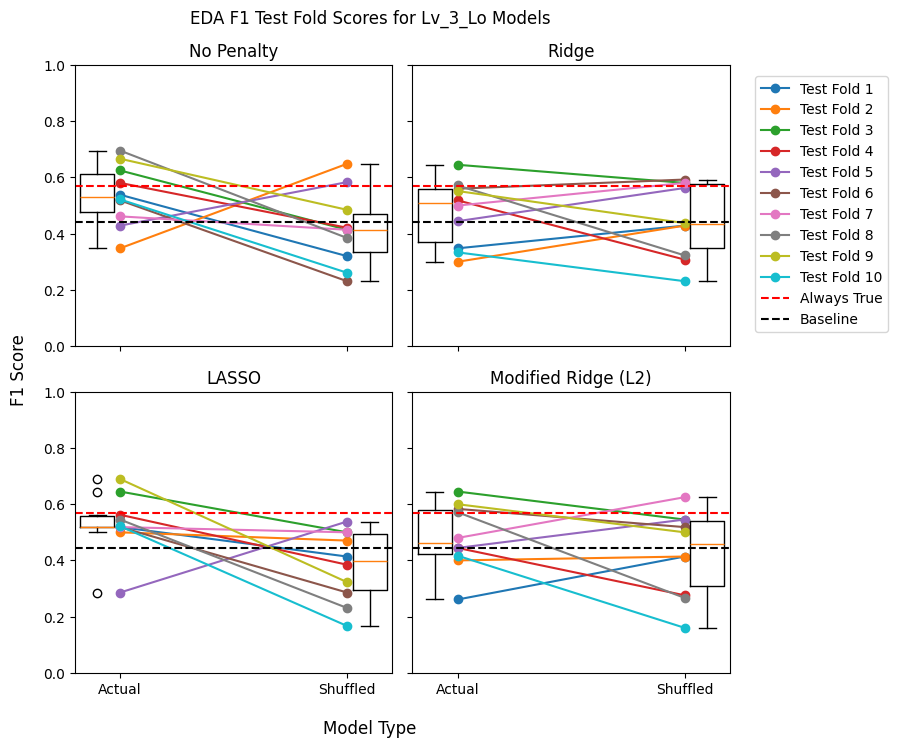

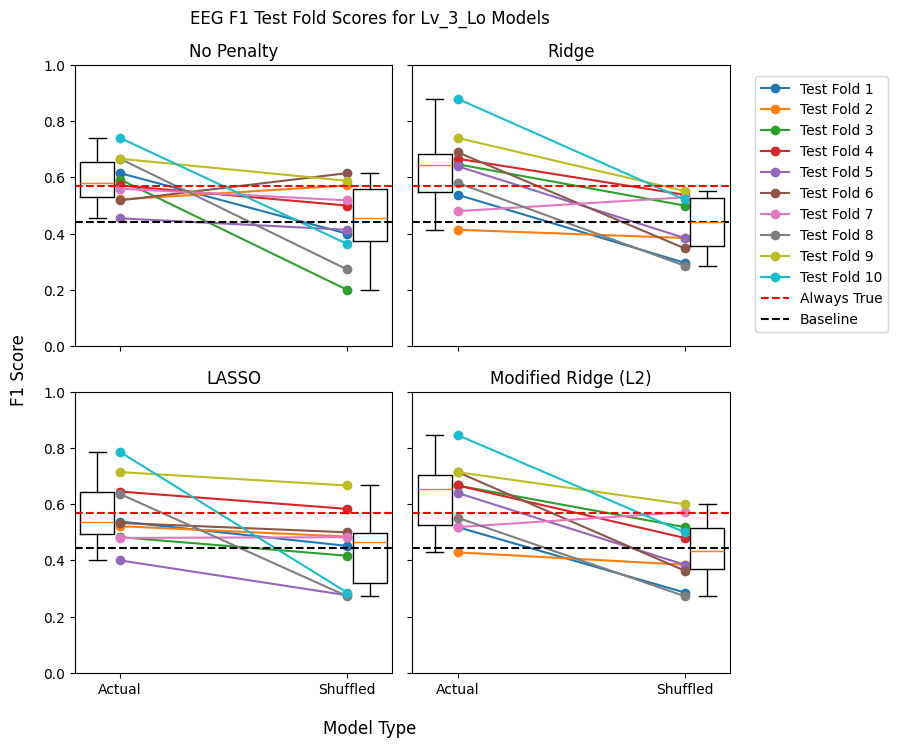

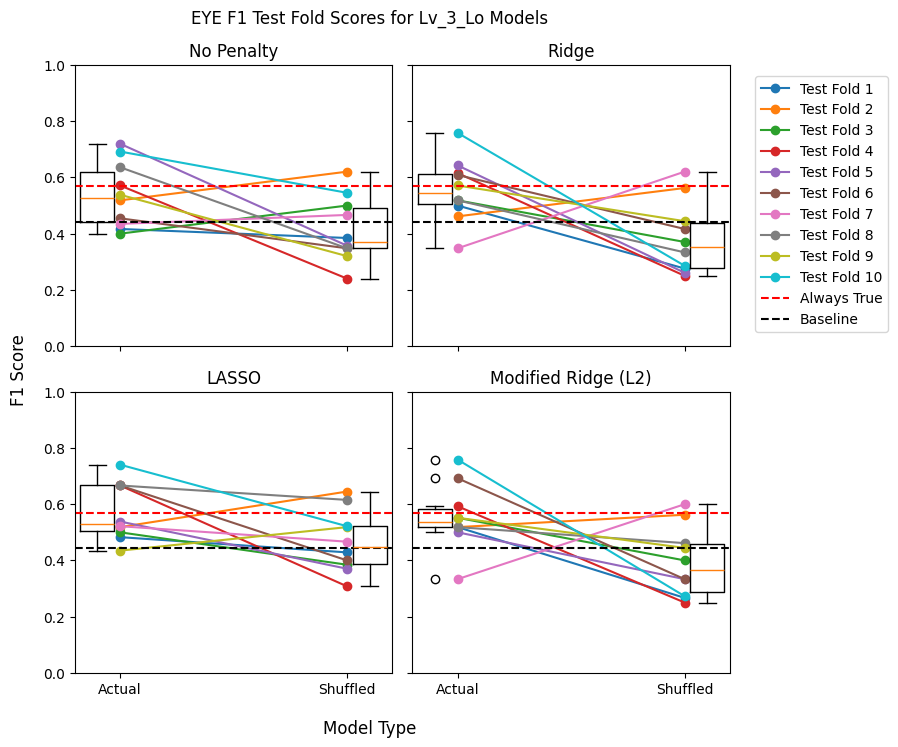

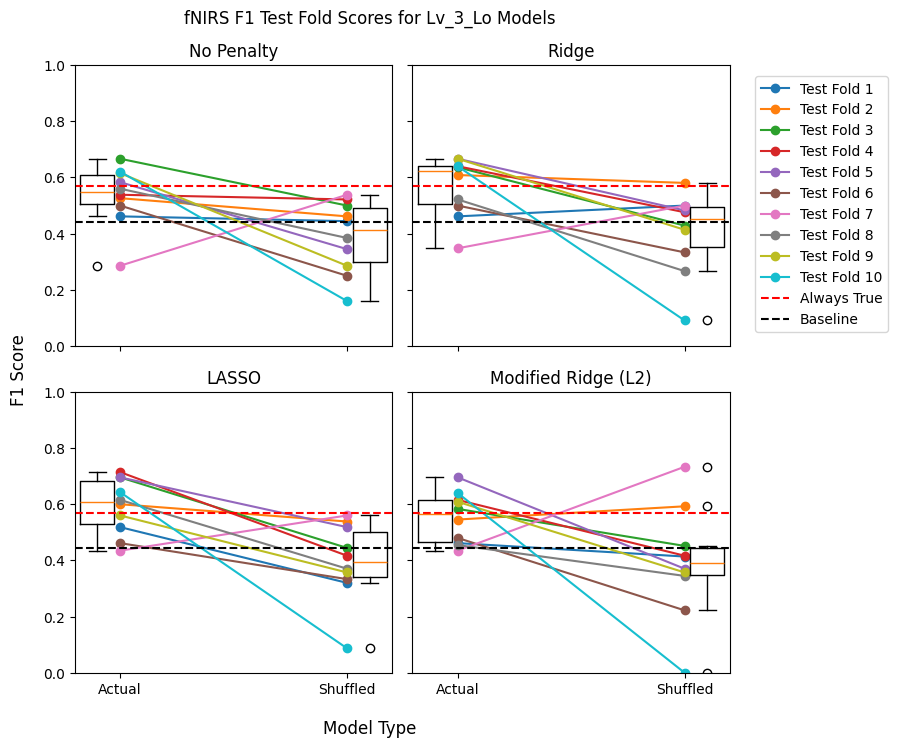

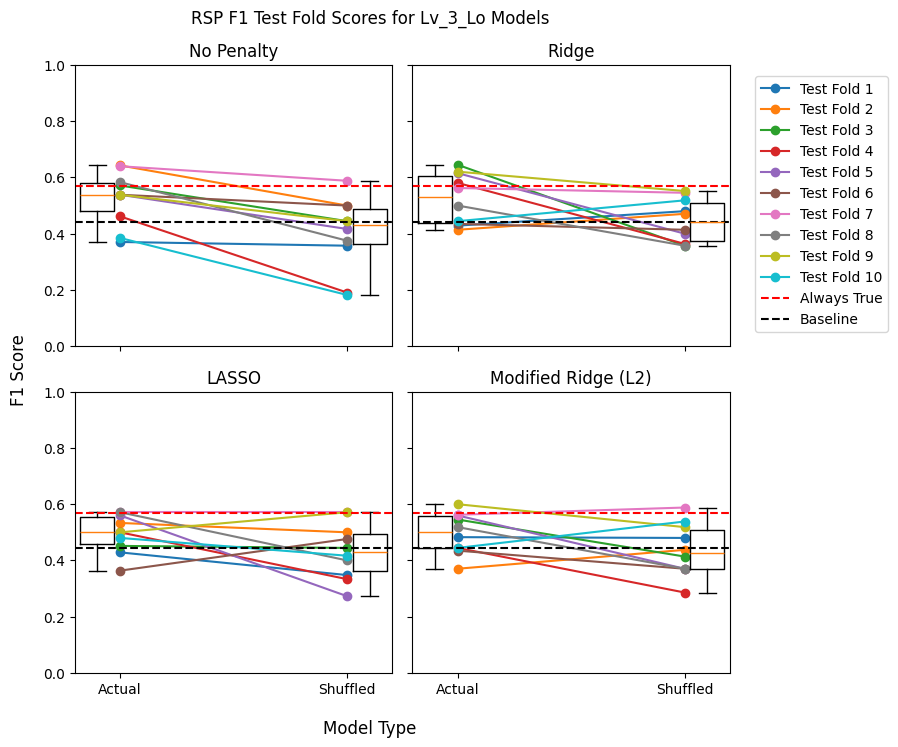

In [30]:
sensor_actual_vs_shuffled(f1_scores, outcomes_df, "Lv_3_Lo", "F1")

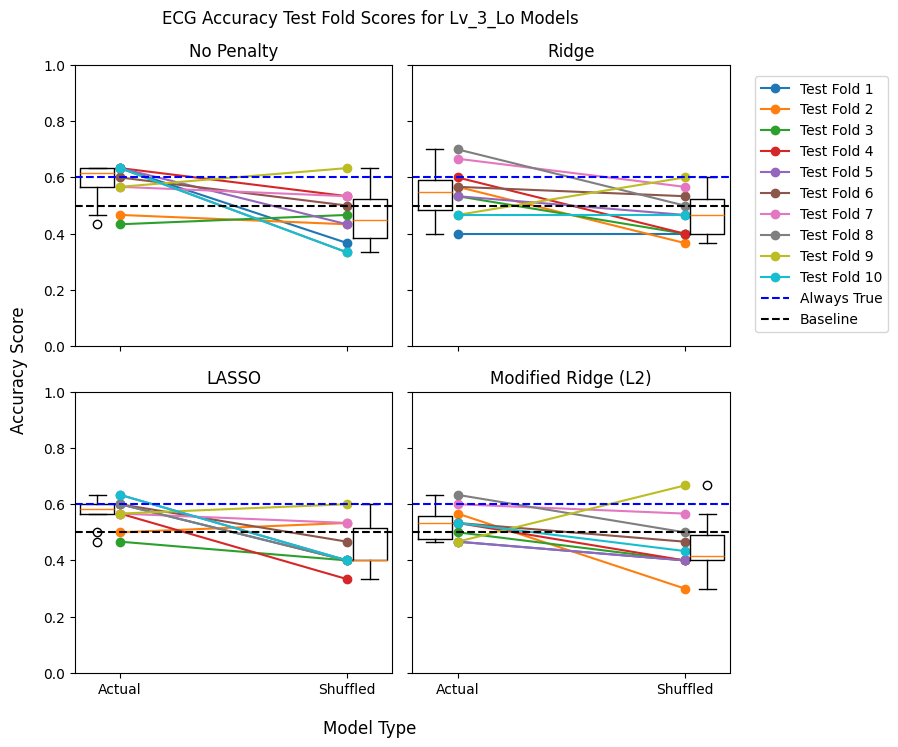

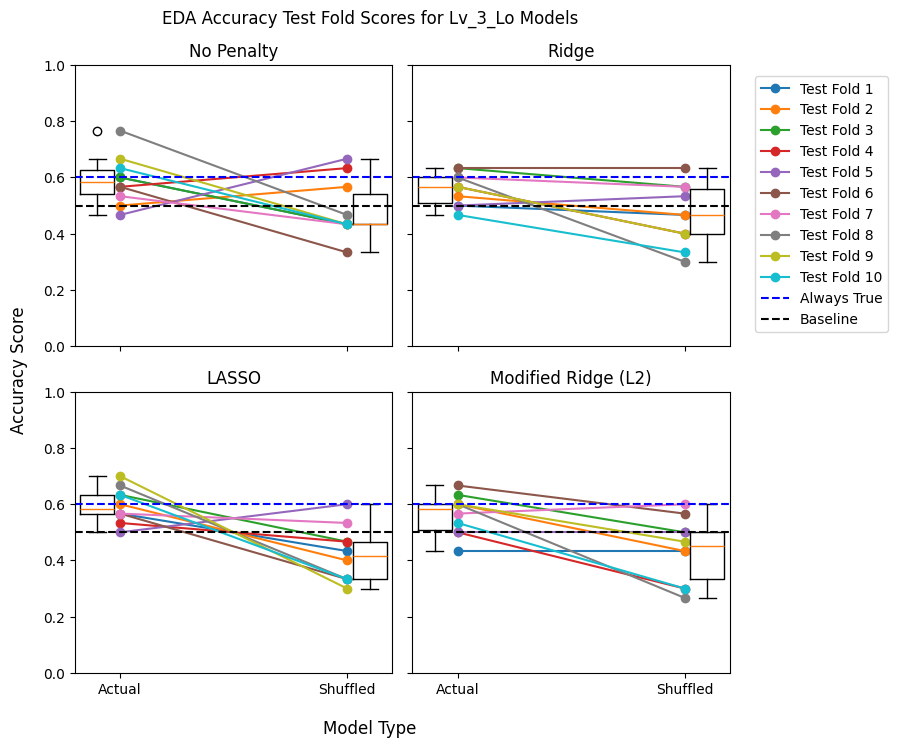

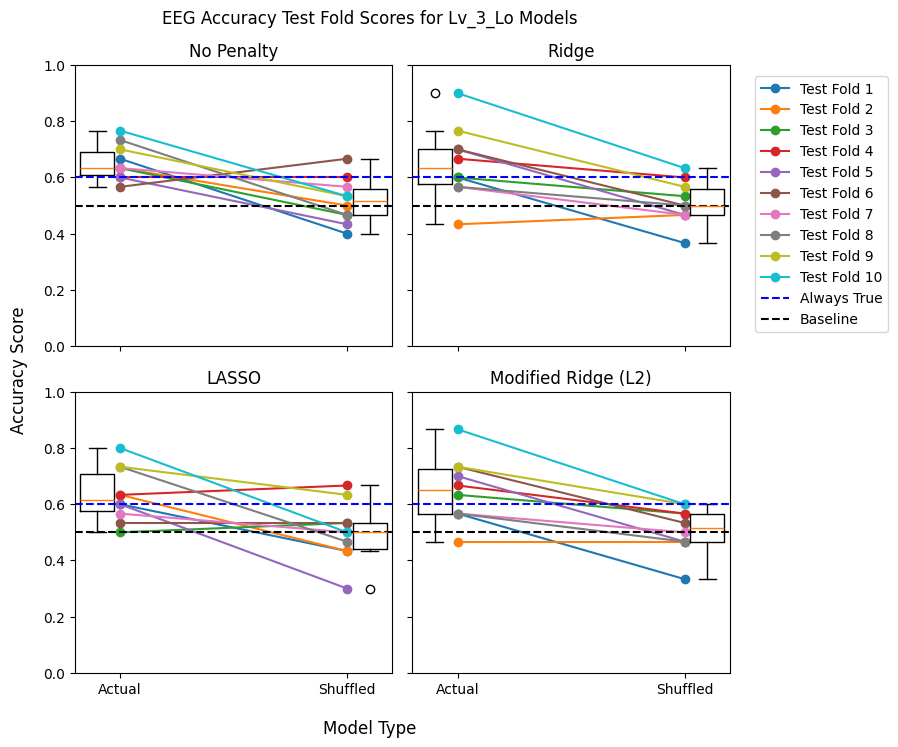

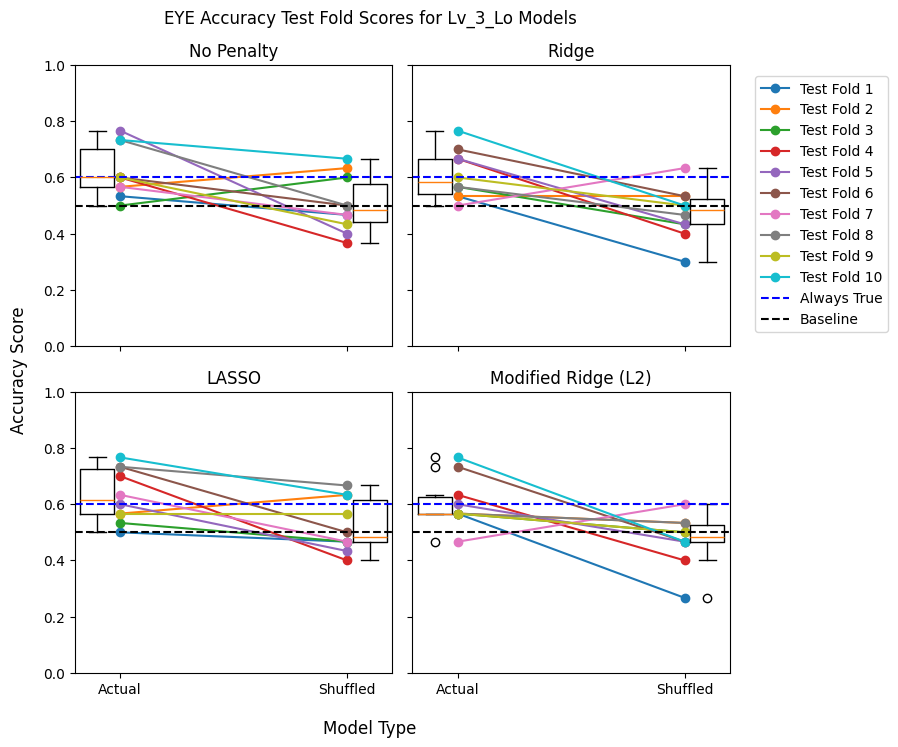

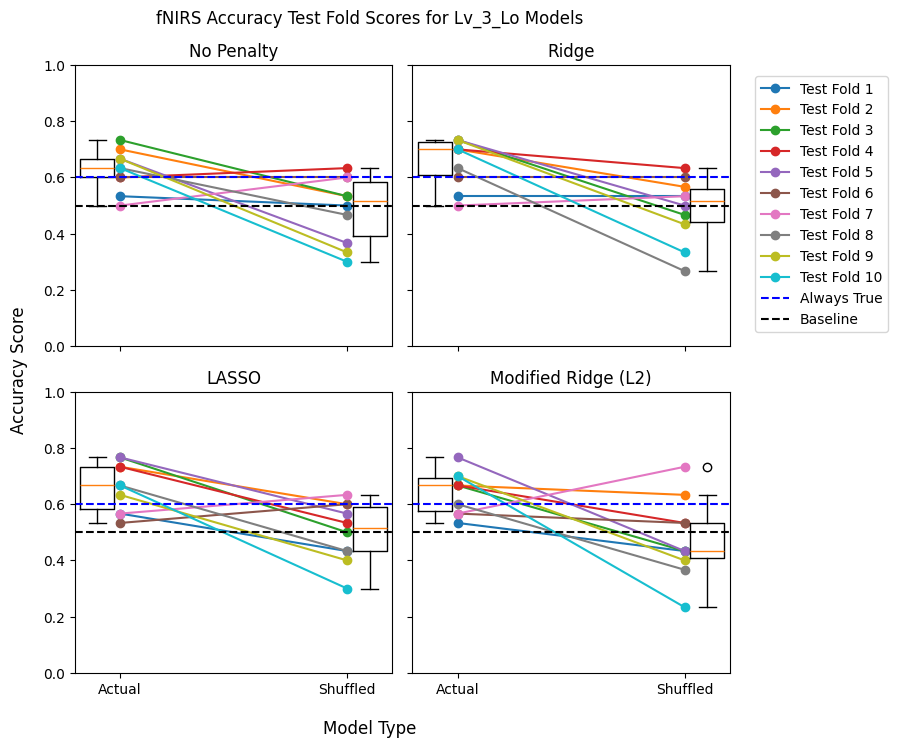

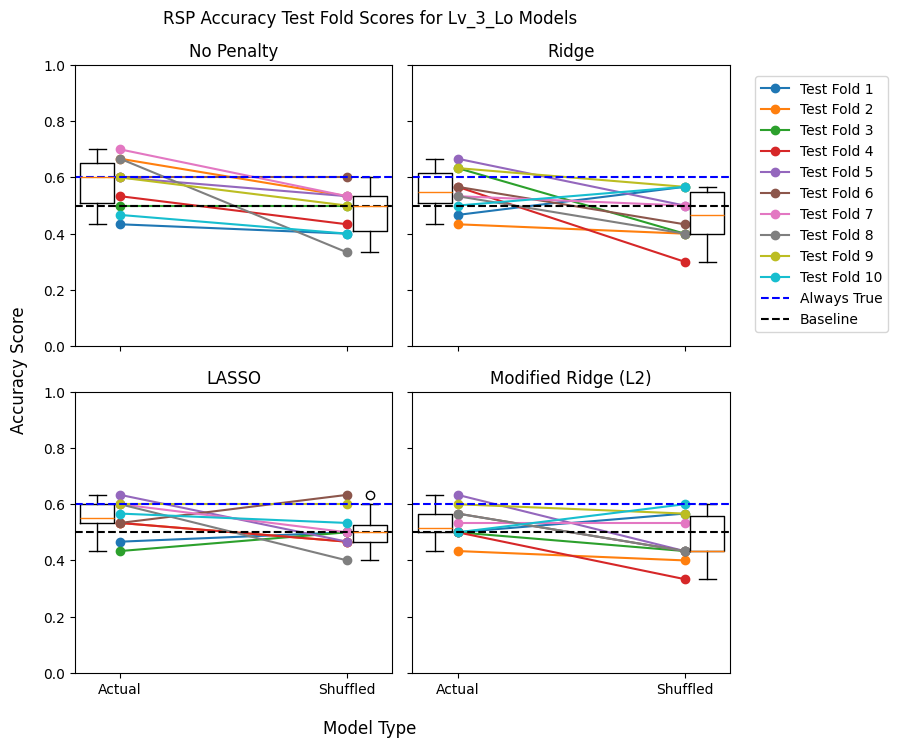

In [40]:
sensor_actual_vs_shuffled(accuracy_scores, outcomes_df, "Lv_3_Lo", "Accuracy")

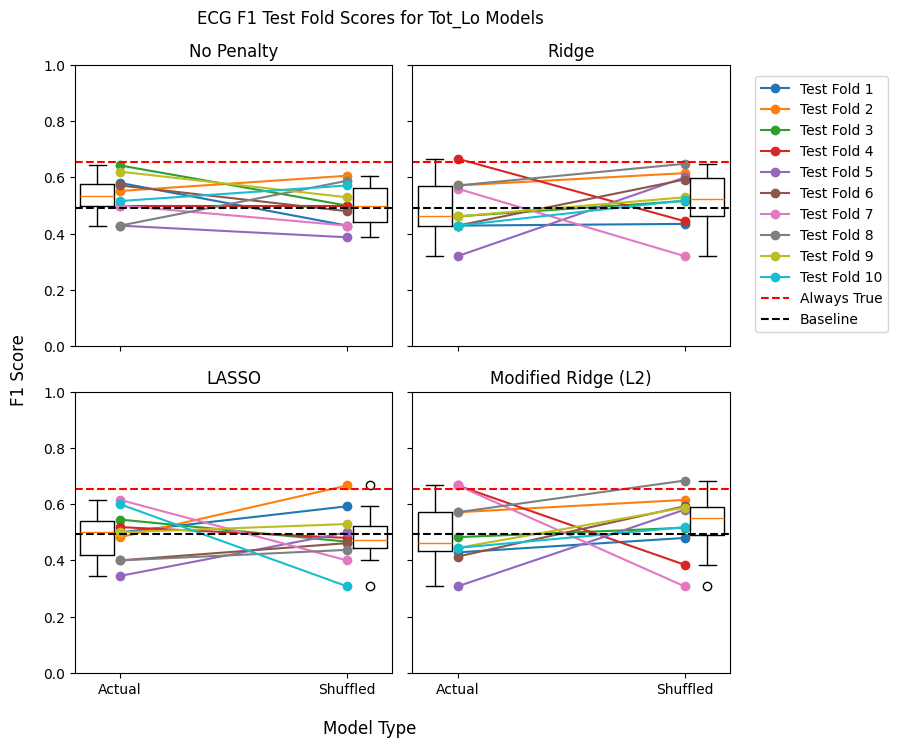

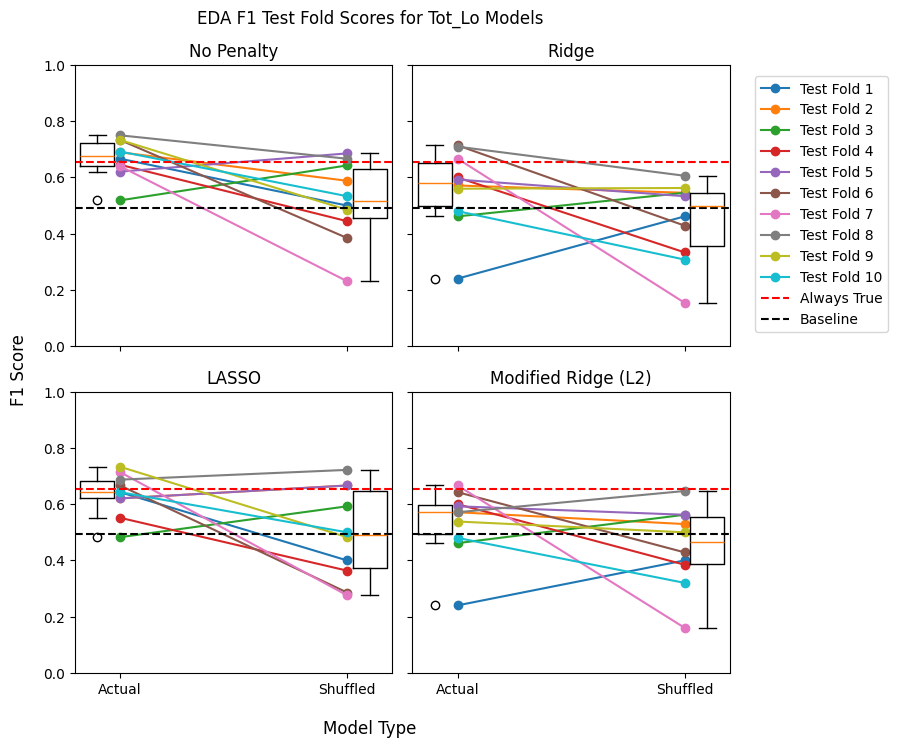

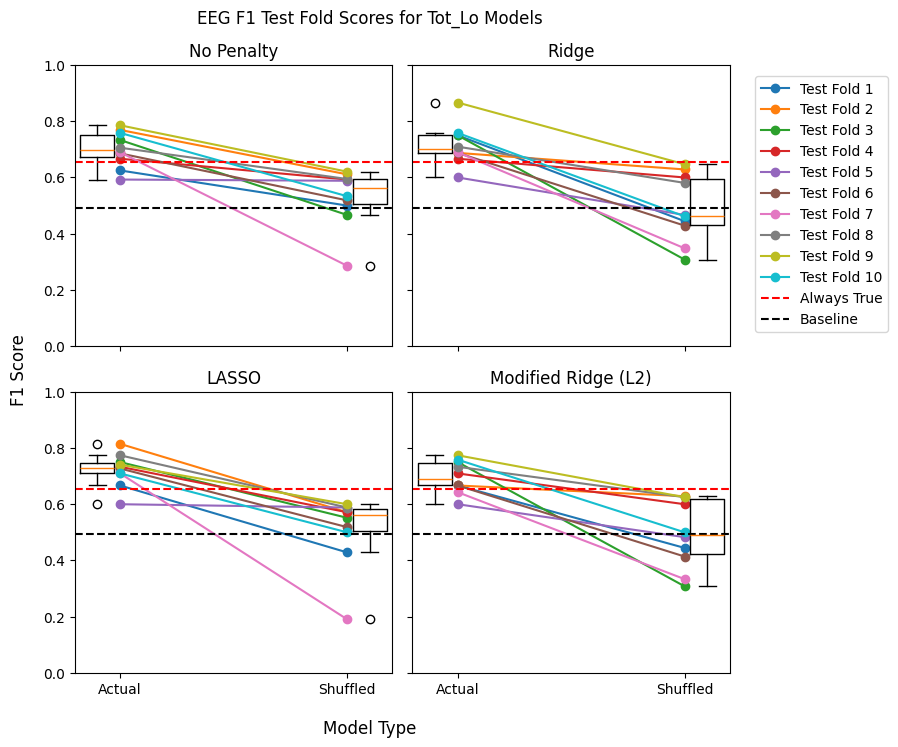

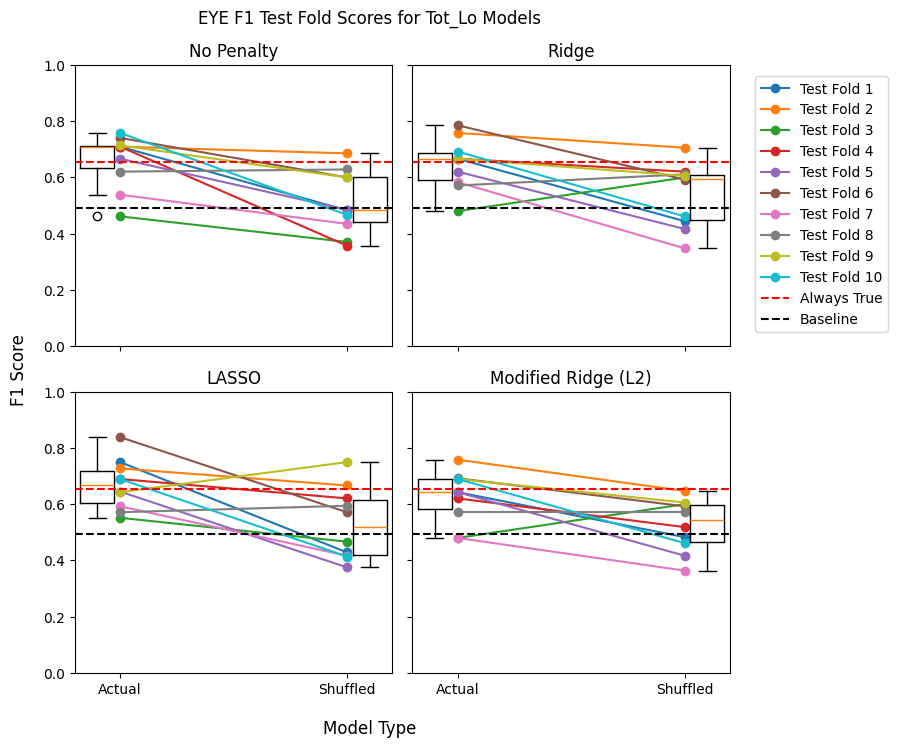

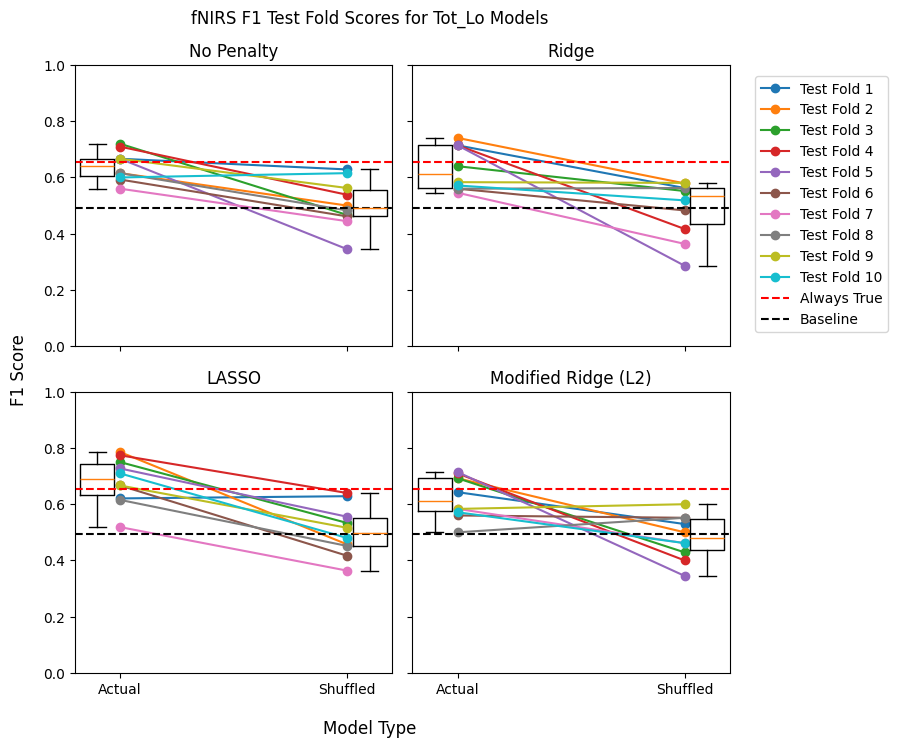

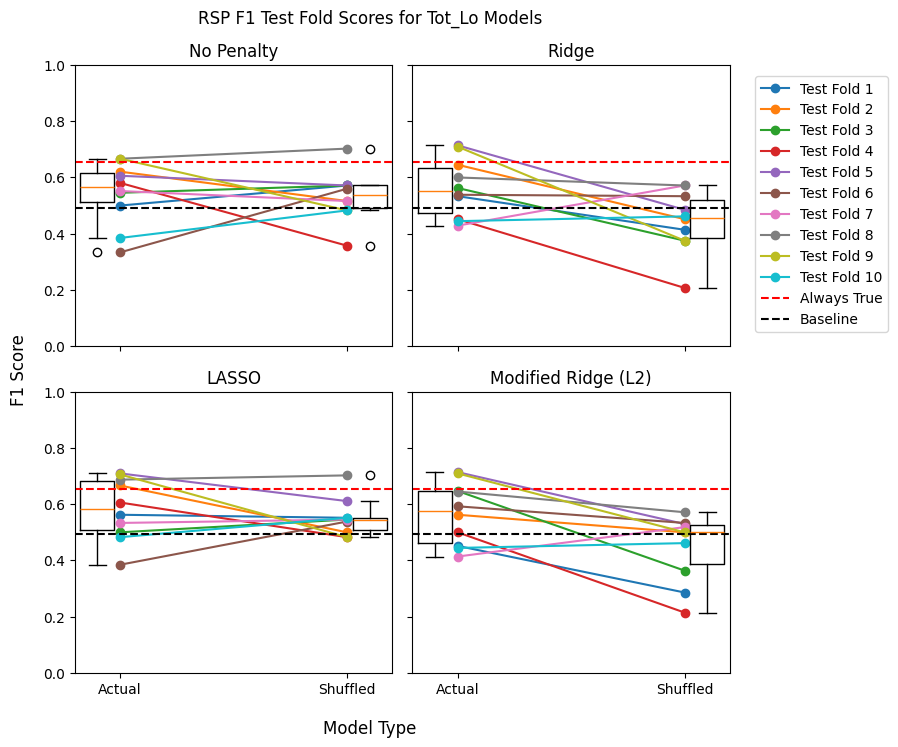

In [32]:
sensor_actual_vs_shuffled(f1_scores, outcomes_df, "Tot_Lo", "F1")

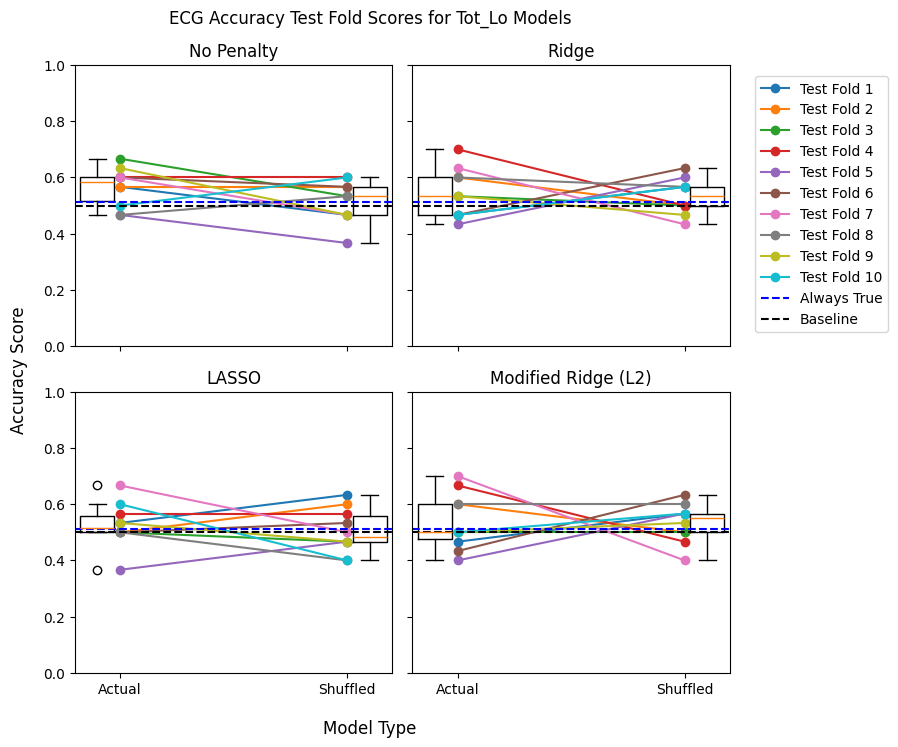

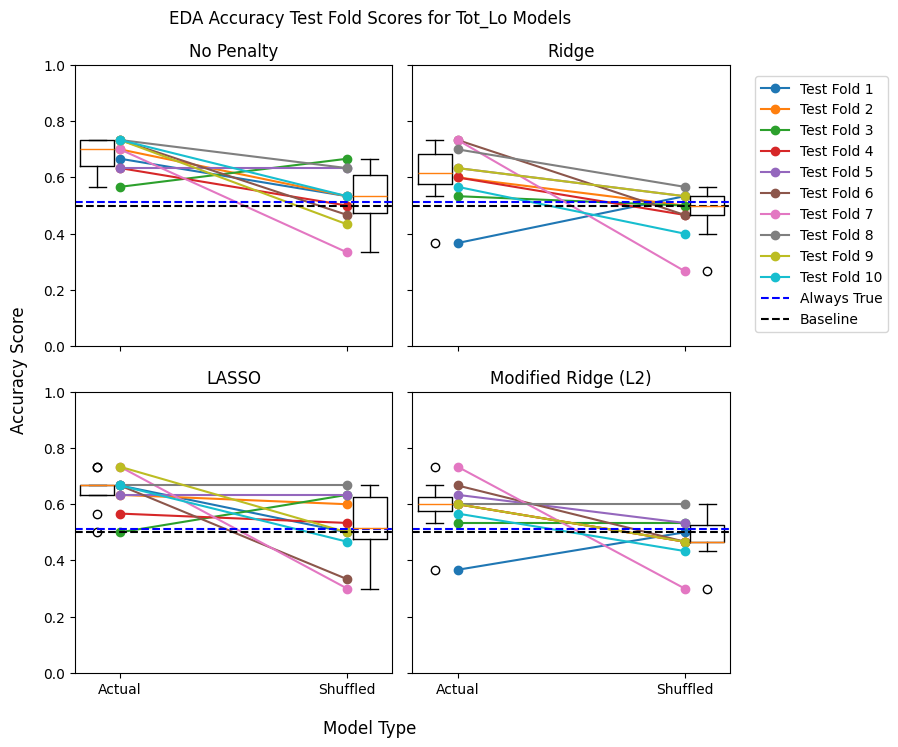

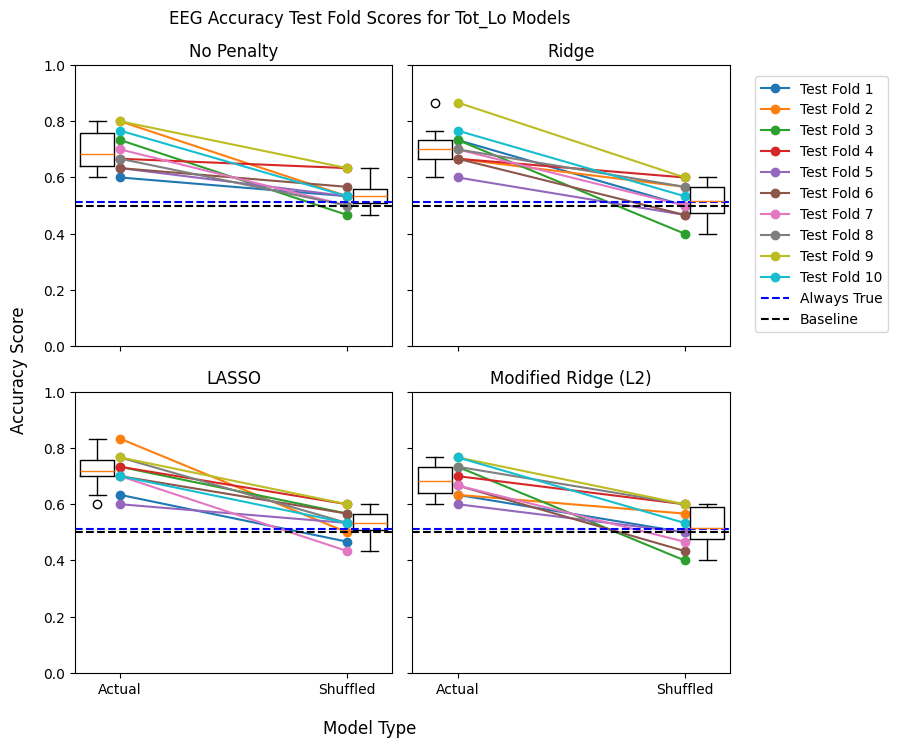

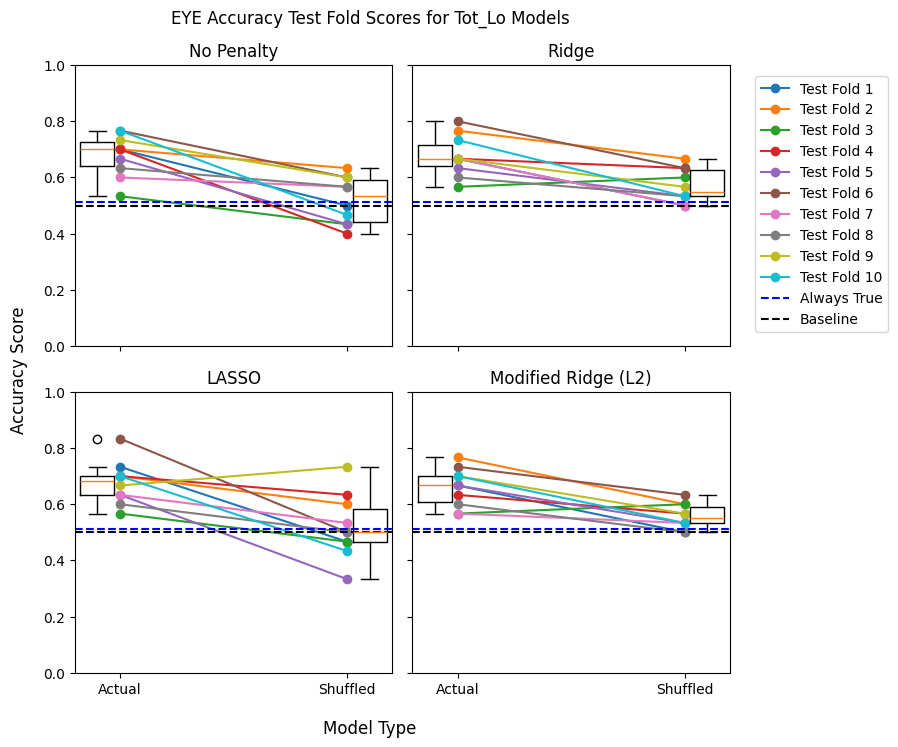

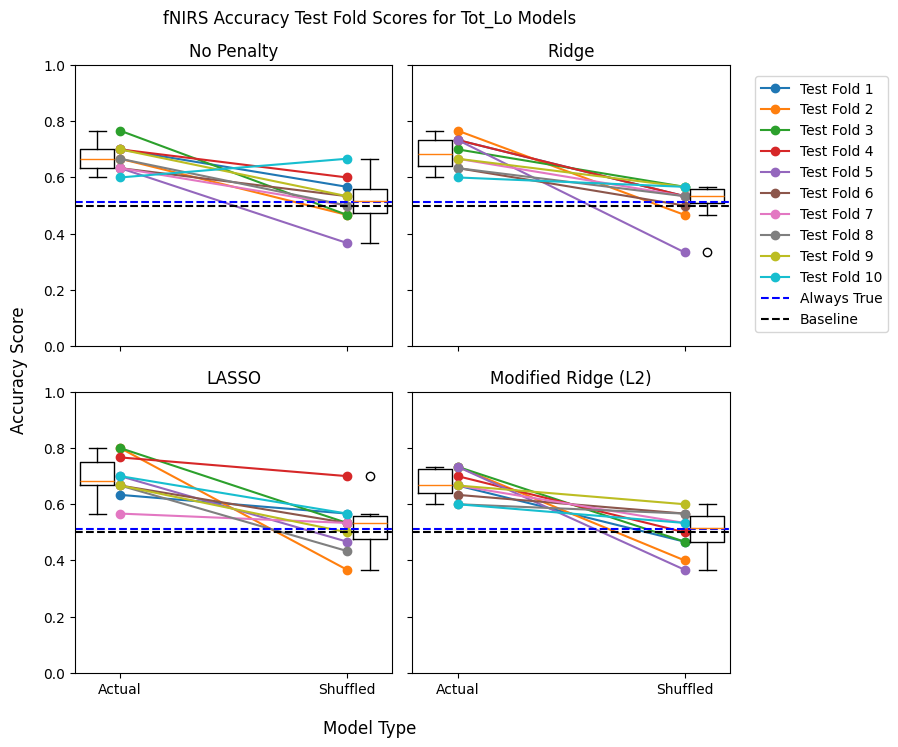

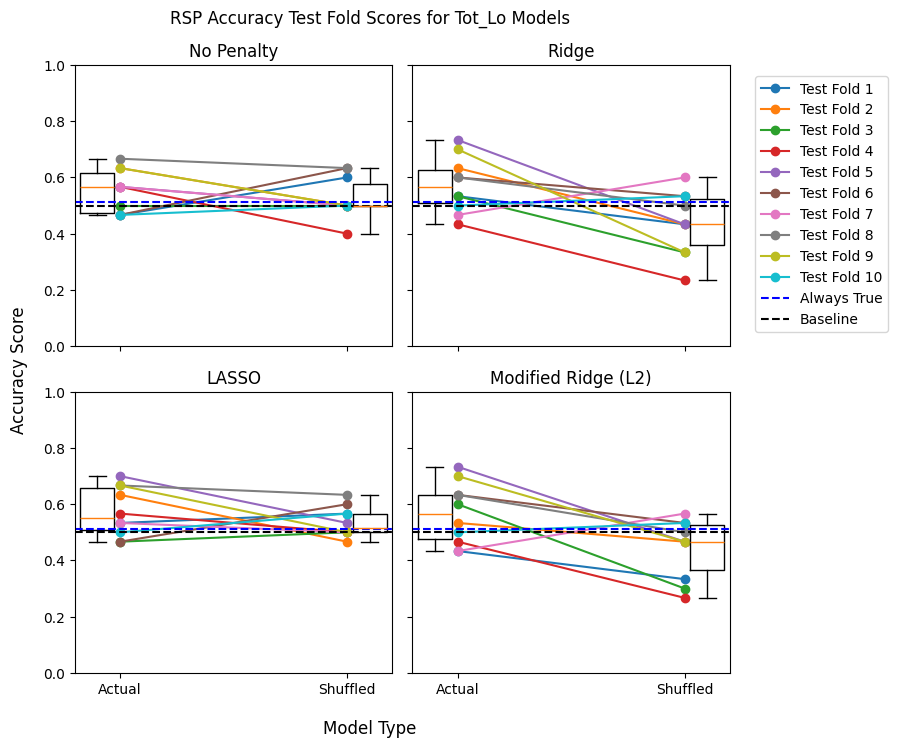

In [41]:
sensor_actual_vs_shuffled(accuracy_scores, outcomes_df, "Tot_Lo", "Accuracy")

# Significance Tests

In [36]:
def actual_vs_shuffled_t_test(model_scores, lvl):
    print("Paired (Actual vs. Shuffled)")
    for sensor in ["ECG", "EDA", "EEG", "EYE", "fNIRS", "RSP"]:
        print(sensor)
        print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
        for penalty in ["No Penalty", "Ridge", "Modified Ridge (L2)", "LASSO"]:
            t_stat, p_val = stats.ttest_rel(
                model_scores["Actual"][sensor][lvl][penalty],
                model_scores["Shuffled"][sensor][lvl][penalty]
            )
            print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')
        print()

In [ ]:
def paired_t_test(model_1_details, model_2_details, lvl):
    print("Paired (Not Shuffled vs. Shuffled)")
    print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
    for penalty in ["No Penalty", "Ridge", "Modified Ridge (L2)", "LASSO"]:
        t_stat, p_val = stats.ttest_rel(
            model_1_details["Data"][model_1_details["Dataset Type"]][lvl][penalty],
            model_2_details["Data"][model_2_details["Dataset Type"]][lvl][penalty]    
        )
        print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

def f1_baseline_t_test(model_f1_scores, predictors_df, outcomes_df, outcome_var, ids):
    print("One Sample (vs. F1 Baseline)")
    print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
    
    # Gather F1 baseline for each fold
    baseline_f1_scores = []
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (CV_idx, test_idx) in enumerate(skf.split(predictors_df, ids)):
        out_test = outcomes_df.loc[test_idx, outcome_var].values

        precision = np.mean(out_test)
        recall = 0.5
        baseline_f1_scores.append(np.mean((2 * precision * recall) / (precision + recall)))

    # Single-Sample t-test for each penalty
    for penalty in ["No Penalty", "Ridge", "Modified Ridge (L2)", "LASSO"]:
        t_stat, p_val = stats.ttest_1samp(
            a = model_f1_scores["Actual"][outcome_var][penalty], 
            popmean = np.mean(baseline_f1_scores))
        print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

def f1_always_true_t_test(model_f1_scores, predictors_df, outcomes_df, outcome_var, ids):
    print("One Sample (vs. Always True Baseline)")
    print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')

    baseline_always_true_values = []
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (CV_idx, test_idx) in enumerate(skf.split(predictors_df, ids)):
        out_test = outcomes_df.loc[test_idx, outcome_var].values

        baseline_always_true_values.append(f1_score(out_test, np.array([1 for _ in range(len(out_test))])))
    
    for penalty in ["No Penalty", "Ridge", "Modified Ridge (L2)", "LASSO"]:
        t_stat, p_val = stats.ttest_1samp(
            a = model_f1_scores["Actual"][outcome_var][penalty], 
            popmean = np.mean(baseline_always_true_values))
        print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

def accuracy_baseline_t_test(model_accuracy_scores, outcome_var):
    for penalty in ["No Penalty", "Ridge", "Modified Ridge (L2)", "LASSO"]:
        t_stat, p_val = stats.ttest_1samp(
            a = model_accuracy_scores["Actual"][outcome_var][penalty], 
            popmean = 0.5)
        print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

{'Actual': {'ECG': {'Lv_1_Lo': defaultdict(list,
               {'No Penalty': [np.float64(0.6206896551724138),
                 np.float64(0.6666666666666666),
                 np.float64(0.4166666666666667),
                 np.float64(0.36363636363636365),
                 np.float64(0.48),
                 np.float64(0.56),
                 np.float64(0.5),
                 np.float64(0.46153846153846156),
                 np.float64(0.7333333333333333),
                 np.float64(0.6)],
                'Ridge': [np.float64(0.46153846153846156),
                 np.float64(0.6),
                 np.float64(0.48),
                 np.float64(0.36363636363636365),
                 np.float64(0.4166666666666667),
                 np.float64(0.5384615384615384),
                 np.float64(0.42105263157894735),
                 np.float64(0.5833333333333334),
                 np.float64(0.5384615384615384),
                 np.float64(0.6206896551724138)],
                'LASSO': [np

In [37]:
actual_vs_shuffled_t_test(f1_scores, "Lv_1_Lo")

Paired (Actual vs. Shuffled)
ECG
Penalty                       t      p      
No Penalty                    4.016  0.003
Ridge                         2.573  0.030
Modified Ridge (L2)           2.441  0.037
LASSO                         2.967  0.016

EDA
Penalty                       t      p      
No Penalty                    2.358  0.043
Ridge                         1.239  0.247
Modified Ridge (L2)           1.602  0.144
LASSO                         3.556  0.006

EEG
Penalty                       t      p      
No Penalty                    2.132  0.062
Ridge                         3.249  0.010
Modified Ridge (L2)           2.939  0.017
LASSO                         2.649  0.027

EYE
Penalty                       t      p      
No Penalty                    1.506  0.166
Ridge                         6.437  0.000
Modified Ridge (L2)           6.152  0.000
LASSO                         2.166  0.058

fNIRS
Penalty                       t      p      
No Penalty                    2.

In [42]:
actual_vs_shuffled_t_test(accuracy_scores, "Lv_1_Lo")

Paired (Actual vs. Shuffled)
ECG
Penalty                       t      p      
No Penalty                    4.823  0.001
Ridge                         5.186  0.001
Modified Ridge (L2)           5.129  0.001
LASSO                         3.899  0.004

EDA
Penalty                       t      p      
No Penalty                    2.548  0.031
Ridge                         1.300  0.226
Modified Ridge (L2)           1.913  0.088
LASSO                         3.973  0.003

EEG
Penalty                       t      p      
No Penalty                    3.767  0.004
Ridge                         5.524  0.000
Modified Ridge (L2)           5.524  0.000
LASSO                         3.184  0.011

EYE
Penalty                       t      p      
No Penalty                    2.079  0.067
Ridge                         8.518  0.000
Modified Ridge (L2)           7.246  0.000
LASSO                         3.500  0.007

fNIRS
Penalty                       t      p      
No Penalty                    6.